# 🦠 COVID-19 Forecasting 😷

The White House Office of Science and Technology Policy (OSTP) pulled together a coalition research groups and companies (including Kaggle) to prepare the COVID-19 Open Research Dataset (CORD-19) to attempt to address key open scientific questions on COVID-19. Those questions are drawn from National Academies of Sciences, Engineering, and Medicine’s (NASEM) and the World Health Organization (WHO).

## Initial imports
In this section we will set up the libraries that will be used in the notebook and open the data (train, test, submit).

In [ ]:
# Run this command if there is an error:
# treemap() got an unexpected keyword argument 'path' 
!pip install --upgrade plotly

ERROR: Operation cancelled by user


In [ ]:
# Used to access the dataset on personal Google Drive
from google.colab import drive

# Used for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Used to get numeric columns in the dataset
from pandas.api.types import is_numeric_dtype

# Used for visualizing missing data
import missingno as msno

# Remove notebook warnings
import warnings
warnings.filterwarnings('ignore')

# Used for data imputation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import math

# Used for data preparation
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from scipy import integrate, optimize

# Used for EDA - working with string dates
from datetime import datetime

# Model evaluation metrics
from sklearn.metrics import mean_pinball_loss
from sklearn.metrics import mean_squared_error

# Used for model development
from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
# Explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
import xgboost as xgb

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change the path to your own path
path = "/content/drive/My Drive/Colab Notebooks/Practice/Datasets/COVID-19/Forecasting/"

# Load the file - add the file's name
data_train = pd.read_csv(path+"train.csv")
data_test = pd.read_csv(path+"test.csv")
data_submission = pd.read_csv(path+"submission.csv")

Duplicates could be an issue and cause overfitting. We will have to deal with this issue. Let's first see if the data has any duplicates and remove them.

In [ ]:
print("Training data before drop_duplicates:", data_train.shape)
data_train = data_train.drop_duplicates()
print("Training data after drop_duplicates:", data_train.shape, "\n\n")

print("Testing data before drop_duplicates:", data_test.shape)
data_test = data_test.drop_duplicates()
print("Testing data after drop_duplicates:", data_test.shape, "\n\n")

print("Submission data before drop_duplicates:", data_submission.shape)
data_submission = data_submission.drop_duplicates()
print("Submission data after drop_duplicates:", data_submission.shape, "\n\n")

Training data before drop_duplicates: (969640, 9)
Training data after drop_duplicates: (969640, 9) 


Testing data before drop_duplicates: (311670, 8)
Testing data after drop_duplicates: (311670, 8) 


Submission data before drop_duplicates: (935010, 2)
Submission data after drop_duplicates: (935010, 2) 




## Exploratory Data Analysis
Exploratory Data Analysis (EDA) will allow us to form and establish hypotheses of predictive insights on the data. This will allow us to correctly prepare the data and develop then develop machine learning models that according to the initially formed hypotheses.

First of all let's explore the columns and check if there is any missing data.

In [ ]:
# Initial data column information
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969640 entries, 0 to 969639
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Id              969640 non-null  int64  
 1   County          880040 non-null  object 
 2   Province_State  917280 non-null  object 
 3   Country_Region  969640 non-null  object 
 4   Population      969640 non-null  int64  
 5   Weight          969640 non-null  float64
 6   Date            969640 non-null  object 
 7   Target          969640 non-null  object 
 8   TargetValue     969640 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 74.0+ MB
None


Let's also see the fundamental statistics for the dataset.

In [ ]:
data_train.describe()

,Id,Population,Weight,TargetValue
count,969640.000000,9.696400e+05,969640.000000,969640.000000
mean,484820.500000,2.720127e+06,0.530870,12.563518
std,279911.101847,3.477771e+07,0.451909,302.524795
min,1.000000,8.600000e+01,0.047491,-10034.000000
25%,242410.750000,1.213300e+04,0.096838,0.000000
50%,484820.500000,3.053100e+04,0.349413,0.000000
75%,727230.250000,1.056120e+05,0.968379,0.000000
max,969640.000000,1.395773e+09,2.239186,36163.000000


### Missing data
In order for us to develop machine learning models, we have to explore and deal with the missing data. This will allow us to make more accurate models and predictions.

#### Missing data information
Let's check which columns have missing data for all of the data - train and test.

In [ ]:
# Inspect which columns have missing values and how many

# Display missing training data
print("Missing training data: \n\n{}\n" .format(data_train.isna().sum()))
print("_"* 26, "\n\n")

# Display missing testing data
print("Missing test data: \n\n{}" .format(data_test.isna().sum()))

Missing training data: 

Id                    0
County            89600
Province_State    52360
Country_Region        0
Population            0
Weight                0
Date                  0
Target                0
TargetValue           0
dtype: int64

__________________________ 


Missing test data: 

ForecastId            0
County            28800
Province_State    16830
Country_Region        0
Population            0
Weight                0
Date                  0
Target                0
dtype: int64


From the latter code it can be concluded that the training amd testing and data have the same missing column. This will allow us to focus mainly on visualizing with data in the training set rather than doing it for all of the datasets. Afterwards the techniques that deal with missing data can be applied to the whole dataset (train, test, submission).

#### Missing data exploration
We will use the `missingno` library in order to quickly and easily visualize the missing data and how it is spread within the dataset. We will using `missingno` barplot, heatmap, matrix and dendogram in order for us to inspect any relations between missing data

##### Barplot
A barplot will allow us to see how many values are missing for every column. 

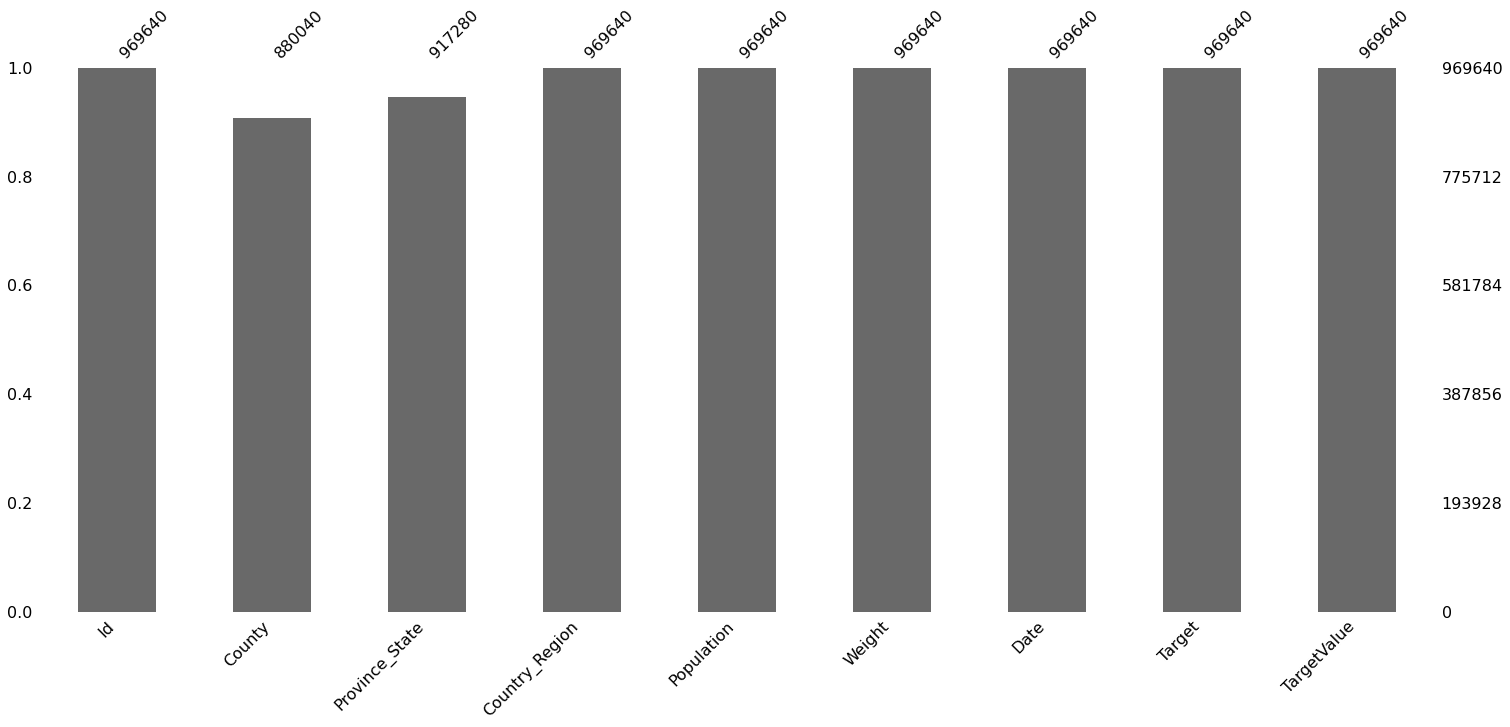

In [ ]:
msno.bar(data_train)
plt.show()

There is not a lot of missing data for the County and Province_State columns.

##### Matrix
A matrix will allow us to see how the missing data is distributed within the data.

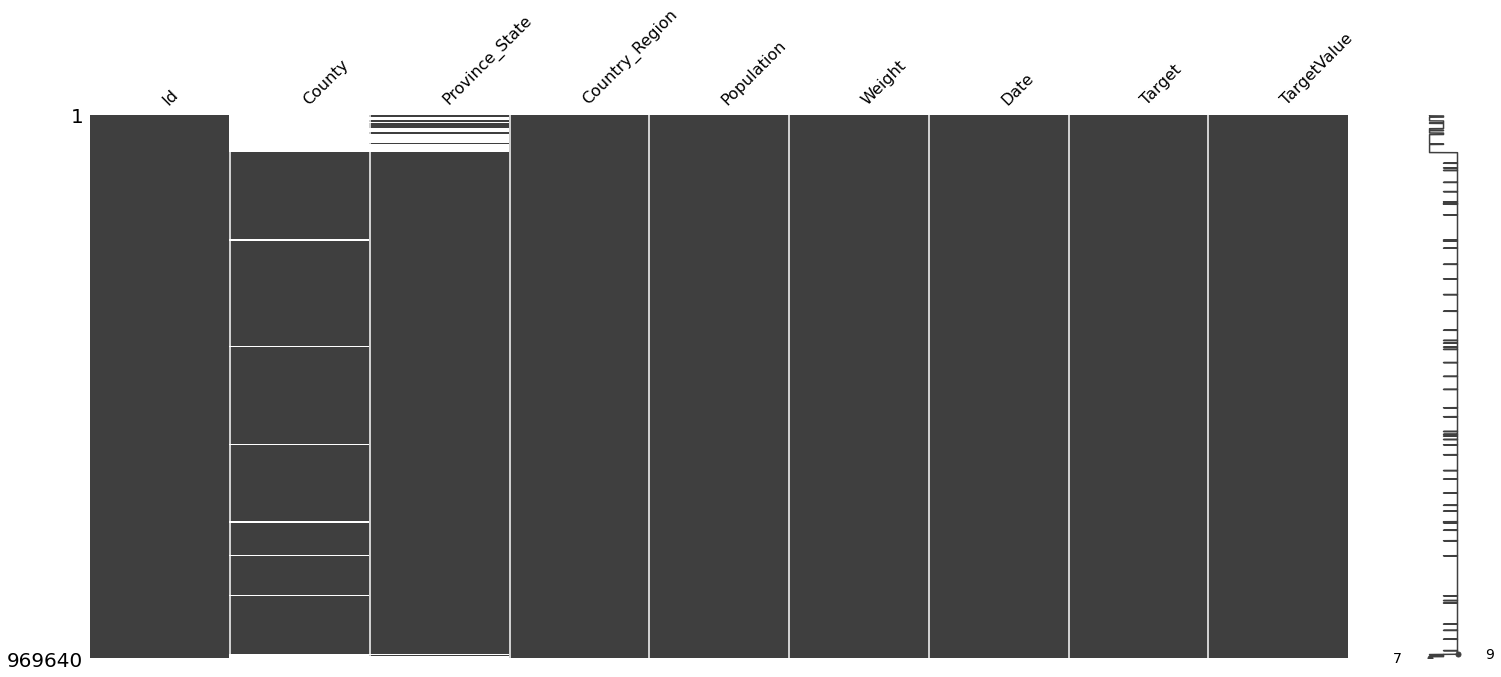

In [ ]:
msno.matrix(data_train)
plt.show()

The missing data is differently skewed, which means that if we drop the NA rows we could lose more data. Although there is plenty of data, it would be best to maximize the data.

##### Heatmap
A heatmap will allow us to explore if there are any relationships between different columns.

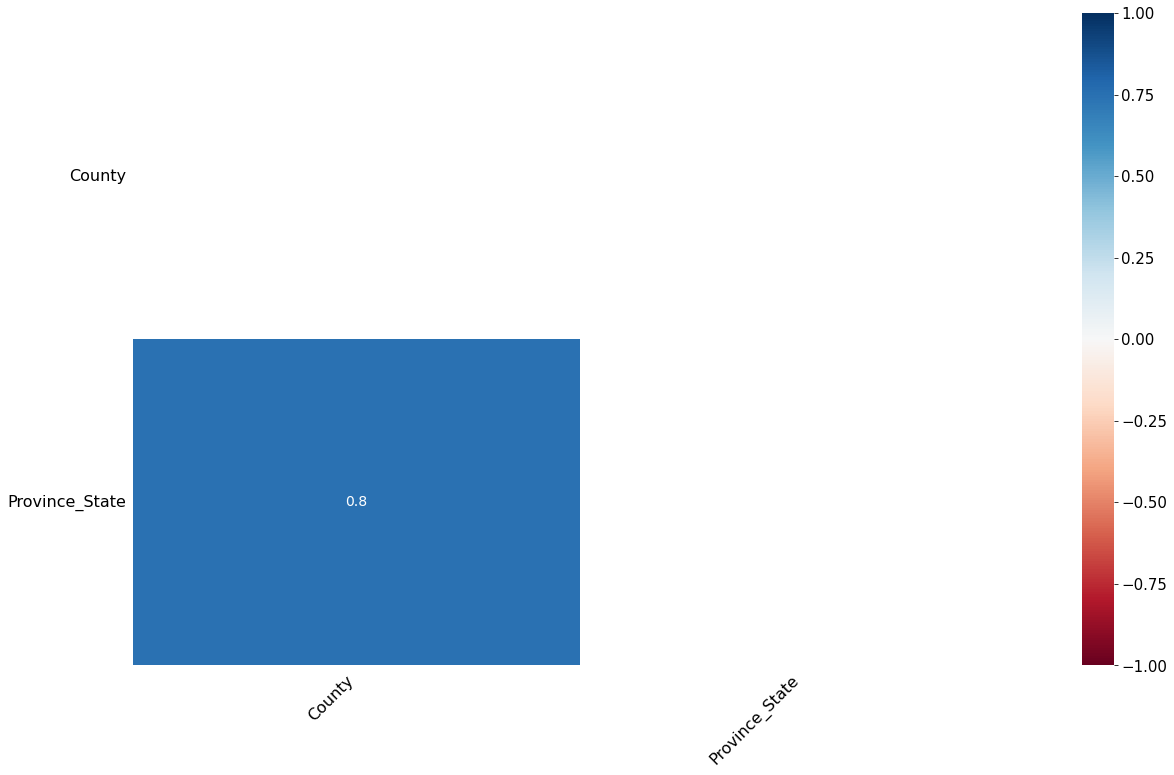

In [ ]:
msno.heatmap(data_train)
plt.show()

The heatmap shows that there is a relation between **Province_State** and **County**, which are the only missing variables

##### Dendogram
A dendogram allows us to see how the missing data is related with each other.

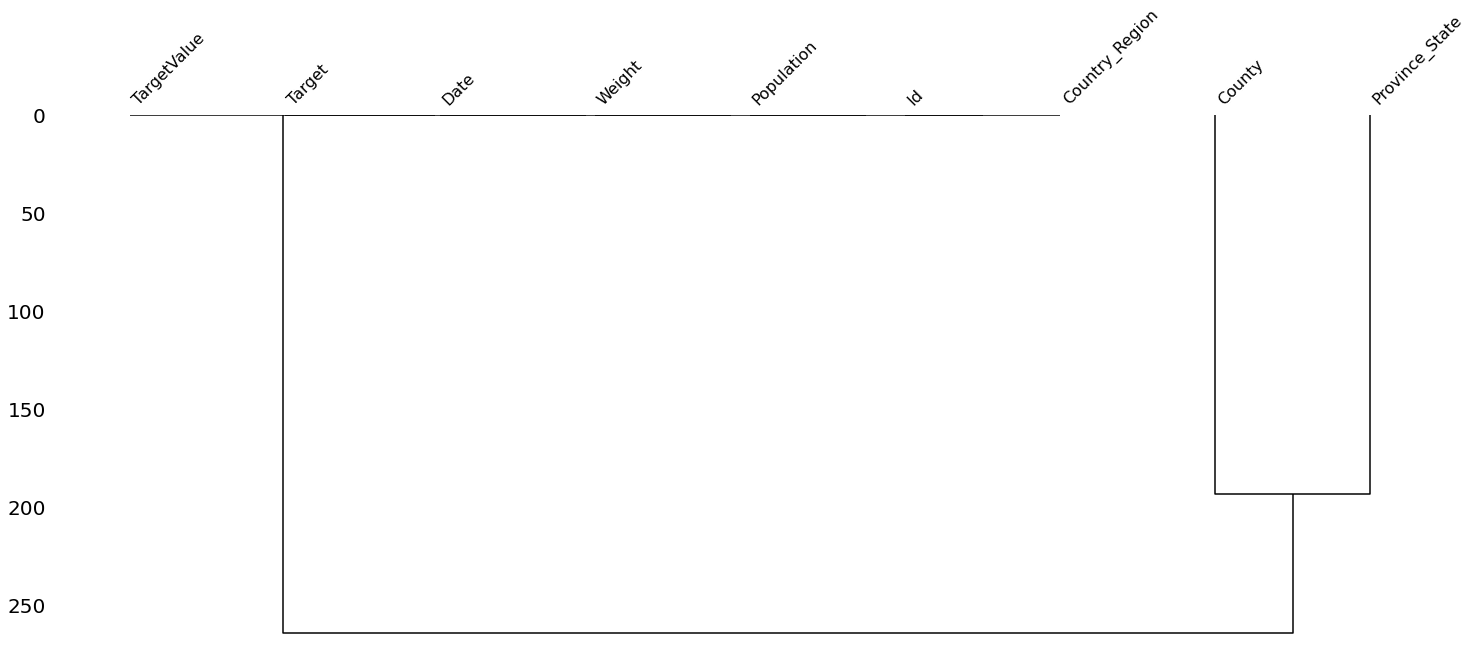

In [ ]:
msno.dendrogram(data_train)
plt.show()

We can see that there is a relation between **Province_State** and **County**, which are the only missing variables and they are directly related to the **Target** (if the missing data is related to **Fatalities** or **Confirmed Cases**. We can conclude taht the missing data is **Missing at Random** (**MAR**) because there is a systematic relationship between the propensity of missing values (**Province_State** and **County**) and the observed data, but not the missing data.

#### Dealing with NAN values


In [ ]:
# Get all NaN rows
nan_data = data_train[data_train.isnull().any(axis=1)].copy()

# Replace the NaN values with the numpy NaN
nan_data['County'] = np.nan
# Province_State column has NaN values and non NaN values, we want to replace only the NaN values with the numpy nan
nan_data.loc[nan_data['Province_State'].isnull(), 'Province_State'] = np.nan

# Get all of the Country_Regions for NaN values
country_regions = nan_data['Country_Region'].unique()

##### **County**
The only country to have counties (aside from NaN) is US. For countries that are not US, we will replace the NaN value with None. Although other countries might have their own counties as well, they are all NaN in the given dataset.

In [ ]:
# Let's see which are the countries in the dataset which have counties
data_train.loc[data_train['County'].notnull(), 'Country_Region'].unique()

array(['US'], dtype=object)

In [ ]:
# Does the US have any missing counties?
usa = data_train[data_train['Country_Region'] == 'US']
print("Number of US rows which have a missing a county: {}" .format(usa[usa['County'].isnull()].shape[0]))

Number of US rows which have a missing a county: 15400


In [ ]:
# Put value None in country counties that are not the US
nan_data.loc[nan_data['Country_Region'] != 'US', 'County'] = 'None'

We have not dealt with all of the missing data in column **County** because the remaining missing values are dependent on the **Province_State** column.

##### **Province_State**
Not all countries have different **Province_State**s as well. Some countries have a no province states (with a defautl value of NaN) and others have. If a country has only 1 value in **Province_State** and it is NaN, it will be replaced with **None**. If a country has more **Province_State** values, we will have to impute the missing values.

In [ ]:
# Let's display all of the countries which have only NaN Province_State

# Display all countries that do not have a Country Region
for country in country_regions:
  # A NAN Country Region country has only 1 unique value in Province_State - nan
  length = len(nan_data.loc[nan_data['Country_Region'] == country, 'Province_State'].unique())
  
  if length == 1:
    array_values = nan_data.loc[nan_data['Country_Region'] == country, 'Province_State'].unique()
    print(length, "\t", array_values, "\t\t", country)

1 	 [nan] 		 Afghanistan
1 	 [nan] 		 Albania
1 	 [nan] 		 Algeria
1 	 [nan] 		 Andorra
1 	 [nan] 		 Angola
1 	 [nan] 		 Antigua and Barbuda
1 	 [nan] 		 Argentina
1 	 [nan] 		 Armenia
1 	 [nan] 		 Austria
1 	 [nan] 		 Azerbaijan
1 	 [nan] 		 Bahamas
1 	 [nan] 		 Bahrain
1 	 [nan] 		 Bangladesh
1 	 [nan] 		 Barbados
1 	 [nan] 		 Belarus
1 	 [nan] 		 Belgium
1 	 [nan] 		 Belize
1 	 [nan] 		 Benin
1 	 [nan] 		 Bhutan
1 	 [nan] 		 Bolivia
1 	 [nan] 		 Bosnia and Herzegovina
1 	 [nan] 		 Botswana
1 	 [nan] 		 Brazil
1 	 [nan] 		 Brunei
1 	 [nan] 		 Bulgaria
1 	 [nan] 		 Burkina Faso
1 	 [nan] 		 Burma
1 	 [nan] 		 Burundi
1 	 [nan] 		 Cabo Verde
1 	 [nan] 		 Cambodia
1 	 [nan] 		 Cameroon
1 	 [nan] 		 Central African Republic
1 	 [nan] 		 Chad
1 	 [nan] 		 Chile
1 	 [nan] 		 Colombia
1 	 [nan] 		 Comoros
1 	 [nan] 		 Congo (Brazzaville)
1 	 [nan] 		 Congo (Kinshasa)
1 	 [nan] 		 Costa Rica
1 	 [nan] 		 Cote d'Ivoire
1 	 [nan] 		 Croatia
1 	 [nan] 		 Cuba
1 	 [nan] 		 Cyprus
1 	 [nan] 		 Cz

In [ ]:
# The latter countries will have a Country_Region of None
for country in country_regions:
  length = len(nan_data.loc[nan_data['Country_Region'] == country, 'Province_State'].unique())

  if length == 1:
    nan_data.loc[nan_data['Country_Region'] == country, 'Province_State'] = 'None'

Let's check how many more missing values are left.

In [ ]:
# Display missing training data
print("Missing nan_data values: \n\n{}\n" .format(nan_data.isna().sum()))

Missing nan_data values: 

Id                    0
County            15400
Province_State     2240
Country_Region        0
Population            0
Weight                0
Date                  0
Target                0
TargetValue           0
dtype: int64



Let's further investigate the countries which have NaN in **Province_State**.

In [ ]:
# Get the Countries which still have a NaN value in Province_State
print("Countries which still have NaN values and have more than 1 value in Province_State: \n\n{}" .format(nan_data.loc[nan_data['Province_State'].isna(), 'Country_Region'].unique()))

Countries which still have NaN values and have more than 1 value in Province_State: 

['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


Let's view all of the **Province_State** values for the **Country_Region**s that have a **Province_State** values NaN.

In [ ]:
# Display the countries and it's provinces which also have NaN values
for country in nan_data.loc[nan_data['Province_State'].isna(), 'Country_Region'].unique():
  print("Country: {}\n" .format(country))
  print("Values:\n\n{}\n\n" .format(nan_data.loc[nan_data['Country_Region'] == country, 'Province_State'].unique()))
  print("Most appeared value(s):\n\n{}\n" .format(nan_data.loc[nan_data['Country_Region'] == country, 'Province_State'].value_counts()))
  print("_"* 80, "\n\n")

Country: Australia

Values:

['Australian Capital Territory' 'New South Wales' 'Northern Territory'
 'Queensland' 'South Australia' 'Tasmania' 'Victoria' 'Western Australia'
 nan]


Most appeared value(s):

Western Australia               280
New South Wales                 280
Australian Capital Territory    280
Northern Territory              280
South Australia                 280
Queensland                      280
Tasmania                        280
Victoria                        280
Name: Province_State, dtype: int64

________________________________________________________________________________ 


Country: Canada

Values:

['Alberta' 'British Columbia' 'Manitoba' 'New Brunswick'
 'Newfoundland and Labrador' 'Northwest Territories' 'Nova Scotia'
 'Ontario' 'Prince Edward Island' 'Quebec' 'Saskatchewan' 'Yukon' nan]


Most appeared value(s):

British Columbia             280
Prince Edward Island         280
Nova Scotia                  280
Newfoundland and Labrador    280
Ontar

We can see that the remaining countries have an equal number of **Province_State**s values. Unfortunately we will not be able to use the **most frequent value** impute strategy because it could impute wrong provinces. In order to deal with the missing NaN values, we will use **KNN Imputation** which will give us the closest values for NaN values. We will not be able to use the `nan_data` variable because it contains only missing variables. For the KNN algorithm we will need the whole dataset in order for the algorithm to approximate the closest values.

In [ ]:
# Update data_train
data_train[data_train.isnull().any(axis=1)] = nan_data

##### **Remaining missing values**

In [ ]:
# See how many NaN values we have remaining in the data_train
print("Missing data remaining:\n\n{}" .format(data_train.isnull().sum()))

Missing data remaining:

Id                    0
County            15400
Province_State     2240
Country_Region        0
Population            0
Weight                0
Date                  0
Target                0
TargetValue           0
dtype: int64


`data_train` has non-numeric values as well which will have to be converted to numbers. Let's first see which columns are non-numeric.

In [ ]:
print("Non numeric  columns:")
non_numeric_columns = []
# Iterate every column index
for i in range(0, len(data_train.columns)):
  # Check if the current column is not numeric
  if not is_numeric_dtype(data_train.dtypes[i]):
    print("- ", data_train.columns[i])
    non_numeric_columns.append(data_train.columns[i])

Non numeric  columns:
-  County
-  Province_State
-  Country_Region
-  Date
-  Target


We do not want to affect the `data_train` variable before we have even visualized the dataset, so we will copy the dataset to a new temporary variable - `iknn_data`.

In [ ]:
# Copy the data to a temp variable
iknn_data = data_train.copy()

# Get the columns that need to be encoded
to_encode = iknn_data[non_numeric_columns]
# Date will be encoded in a different way
to_encode = to_encode.drop('Date', axis=1)

# Now we can convert the variables
to_encode

,County,Province_State,Country_Region,Target
0,None,None,Afghanistan,ConfirmedCases
1,None,None,Afghanistan,Fatalities
2,None,None,Afghanistan,ConfirmedCases
3,None,None,Afghanistan,Fatalities
4,None,None,Afghanistan,ConfirmedCases
...,...,...,...,...
969635,None,None,Zimbabwe,Fatalities
969636,None,None,Zimbabwe,ConfirmedCases
969637,None,None,Zimbabwe,Fatalities
969638,None,None,Zimbabwe,ConfirmedCases


In order for us to figure out the **NaN** values, we need to convert them  from `np.nan` to a string. The data will be encoded with `LabelEncoder`. The dataset is very big (almost 1 million rows) and there are a lot of different features such as different countries and counties.

###### Encodings
**KNNImputer** cannot work with labels, so we will have to convert the non-numeric values to numbers, in order for the algorithm to predict missing values.




Some of the data in **County** and **Province_State** is missing and we will have to do the following steps to convert is successfully:


1.   Convert the `np.nan` values to string `'NaN'`
2.   Use `LabelEncoder` to encode target labels with values between 0 and `n_classes - 1`.
3.   At this point the data is converted to numbers (including the `'NaN'` values). Now the they will be converted back to `np.nan`. The created dictionaries (`le_dictionary` and `dictionary`) will help us convert the data from numbers back to text data.

In [ ]:
nan_columns = ['Province_State', 'County']
# Store the label encoders for every column
le_dictionary = {}
# Store the dictionary for every column
dictionary = {}

to_encode.loc[to_encode['Province_State'].isnull(), 'Province_State'] = 'NaN'
to_encode.loc[to_encode['County'].isnull(), 'County'] = 'NaN'

In [ ]:
# NaN columns
for column in nan_columns:
  # Convert the data from string to numbers
  le = LabelEncoder()
  labels = to_encode[column]
  encodings = le.fit_transform(to_encode[column])
  # np.nan works with floats and we will have to change the int64 to float64
  encodings = encodings.astype(np.float64)
  # Create a dictionary in the format label: encoding
  column_dictionary = dict(zip(labels, encodings))

  # Iterate over every encoded value
  for i in range(0, len(encodings)):
    # Check if current value number is the NaN number
    if encodings[i] == column_dictionary['NaN']:
      # Change the NaN number to np.nan so it can be given to KNNImputer
      encodings[i] = np.nan

  # Add label encoder to dictionary
  le_dictionary[column] = le
  # Add current column dictionary to dictionary
  dictionary[column] = column_dictionary
  # Update column
  to_encode[column] = encodings

Non NaN data is easier to encode because we do not have to check for `'NaN'` values. Instead the column is passed to the encoder, added to the dictionaries and finally `to_encode` is updated. The only non NaN column which will be treated differently will be **Date**.

In [ ]:
# Non NaN columns
other_columns = ['Country_Region', 'Target']

for column in other_columns:
  # Convert the data from string to numbers
  le = LabelEncoder()
  labels = to_encode[column]
  encodings = le.fit_transform(to_encode[column])
  encodings = encodings.astype(np.float64)

  # Create a dictionary in the format label: encoding
  column_dictionary = dict(zip(labels, encodings))

  # Add label encoder to dictionary
  le_dictionary[column] = le
  # Add current column dictionary to dictionary
  dictionary[column] = column_dictionary
  # Update column
  to_encode[column] = encodings

As previously mentioned, **Date** will be treated differently because it consists only from numbers (years, months and days) and we can take the data from the column itself and split it into new columns, rather than using `LabelEncoder`.

In [ ]:
# Dates

# Update iknn_data with the new label encodings
iknn_data[['County', 'Province_State', 'Country_Region', 'Target']] = to_encode

# Convert from String (Object) to Date type
iknn_data.Date = pd.to_datetime(iknn_data.Date)

# Create the Date number columns
iknn_data.insert(6, 'Year', pd.DatetimeIndex(iknn_data.Date).year)
iknn_data.insert(7, 'Month', pd.DatetimeIndex(iknn_data.Date).month)
iknn_data.insert(8, 'Day', pd.DatetimeIndex(iknn_data.Date).day)

# Remove the Date column and TargetValue (number of Confirmed Cases/Fatalities)
iknn_data = iknn_data.drop(['Date', 'TargetValue'], axis=1)

###### Scaling the data
So far the data is converged to numbers but in order for **KNN Imputation** to return more accurate **NaN** predictions. Unscaled data can return more inaccurate results, can impact the performance of the machine learning algorithms and slow down the **KNN Imputation** algorithm.

Before we scale the data, let's see how it is distributed so we can find out the best scaling method for it

[]

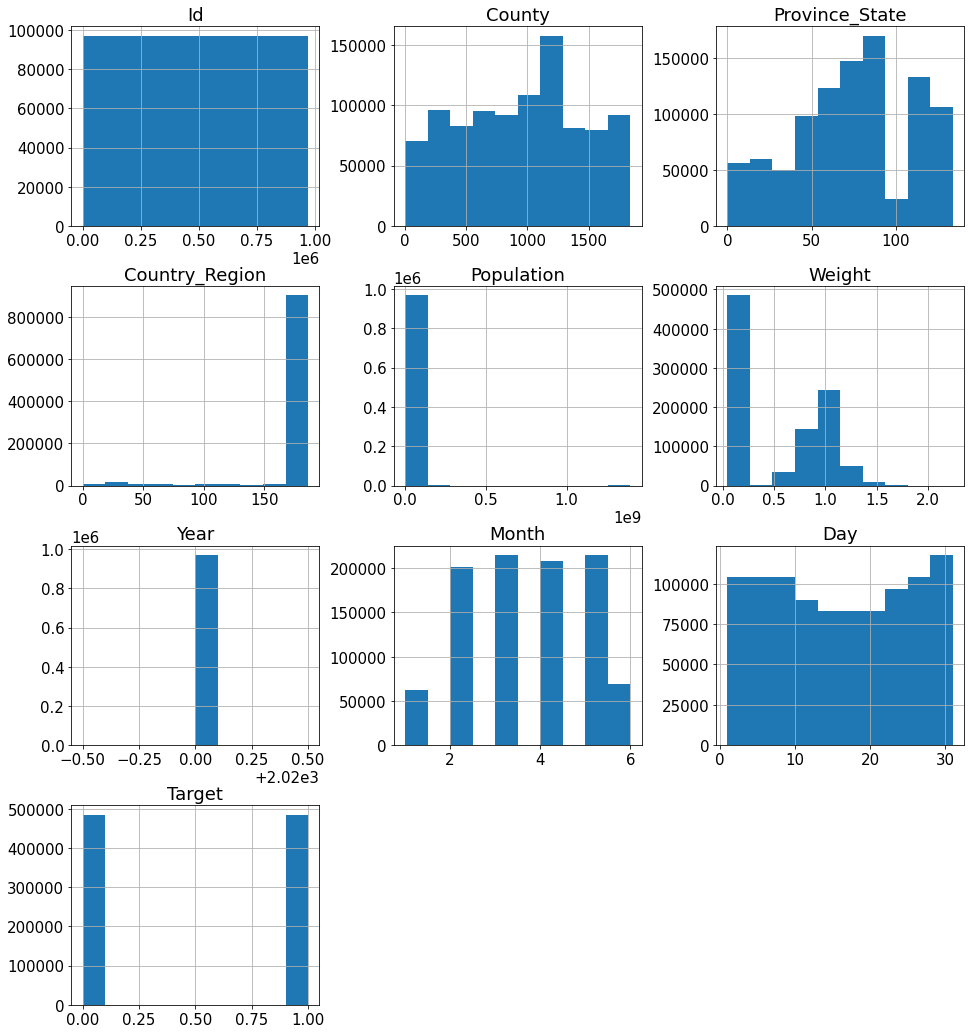

In [ ]:
iknn_data.hist(figsize = (16, 18))
plt.plot()

The data does not follow a Gaussian distribution, which means we will use Normalization rather than Standardization. We will use **Min-Max Scaling** to converge the values between 0 and 1.

In [ ]:
# Get the columns of the iknn_data before it is scaled down
iknn_columns = iknn_data.columns

scaler = MinMaxScaler()
iknn_data = scaler.fit_transform(iknn_data)

###### **KNN Imputation**
KNN for missing values approximates the closest values for the missing values, based on the closest points around the `np.nan` variables. In order for the correct value to be predicted we need to give a number of neighbours that `KNNImputer` will calculate the the missing values.

the `n_neighbors` indicates the count of the nearest neighbours that the algorithm will take into consideration for giving the `np.nan` values a number. 

There are no pre-defined ways of getting the best value of K. Choosing a small number of `n_neighbors` can lead to noisy decisions, whereas large `n_neighbors` values could give better and smoother decisions (lower variance) but high bias.

Instead of try and failiure with `n_neighbors`, [we will choose the square root of N](https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/k-nearest-neighbor) (where N is the total number of data points in the training set) as our `n_neighbors` default value. [In order to avoid algorithm confusions between different class selection we will make the `n_neighbors` value an odd number.](https://towardsdatascience.com/a-simple-introduction-to-k-nearest-neighbors-algorithm-b3519ed98e)

In [ ]:
knn_value = round(math.sqrt(iknn_data.shape[0]))

# If knn_value is even => make odd by incrementing it
if knn_value % 2 == 0:
  knn_value = knn_value + 1

In order not to wait for the long **KNN Imputation** the results have been saved to `train_no_missing_data_iknn.csv` to speed up the results. Feel free to uncomment the code if you would like to run the `KNNImputer`.

In [ ]:
'''
knn_imputer = KNNImputer(n_neighbors=knn_value)
new_iknn_data = knn_imputer.fit_transform(iknn_data)

# Scale up the data
new_iknn_data = scaler.inverse_transform(new_iknn_data)

# Convert to Pandas Dataframe
new_iknn_data = pd.DataFrame(data=new_iknn_data, columns=iknn_columns)

print("Missing values:\n\n{}" .format(new_iknn_data.isna().sum()))

# Save the iknn data to a csv file so it is faster to access
new_iknn_data.to_csv(path + "train_no_missing_data_iknn.csv", index=False)
'''

'\nknn_imputer = KNNImputer(n_neighbors=knn_value)\nnew_iknn_data = knn_imputer.fit_transform(iknn_data)\n\n# Scale up the data\nnew_iknn_data = scaler.inverse_transform(new_iknn_data)\n\n# Convert to Pandas Dataframe\nnew_iknn_data = pd.DataFrame(data=new_iknn_data, columns=iknn_columns)\n\nprint("Missing values:\n\n{}" .format(new_iknn_data.isna().sum()))\n\n# Save the iknn data to a csv file so it is faster to access\nnew_iknn_data.to_csv(path + "train_no_missing_data_iknn.csv", index=False)\n'

In [ ]:
# If you have uncommented the latter code cell, please comment out this code cell
new_iknn_data = pd.read_csv(path+"train_no_missing_data_iknn.csv")

Now the dataset does not have any missing values and we can focus on converting the numbers back to labels (as they were originally).

In [ ]:
print("Missing values in new_iknn_data:\n\n{}" .format(new_iknn_data.isna().sum()))

Missing values in new_iknn_data:

Id                0
County            0
Province_State    0
Country_Region    0
Population        0
Weight            0
Year              0
Month             0
Day               0
Target            0
dtype: int64


In [ ]:
# Normal flow - no need to touch this part :)
columns_to_fix = ['Id', 'County', 'Province_State', 'Country_Region', 'Population', 'Target']

# Convert from float64 to int64 as it originally was
for column in columns_to_fix:
  new_iknn_data[column] = new_iknn_data[column].astype(np.int64)

# Drop newly created rows
new_iknn_data = new_iknn_data.drop(labels=['Year', 'Month', 'Day'], axis=1)

Now that the data has been converted back to normal, we can convert the label numbers to the original labels they had with the help of `le_dictionary` and the `inverse_transform` function which reverts the numbers to the original labels.

In [ ]:
for column in le_dictionary.keys():
  new_iknn_data[column] = le_dictionary[column].inverse_transform(new_iknn_data[column])

In [ ]:
# Update the NaN values in data_train with the imputed knn values
data_train[['County', 'Province_State']] = new_iknn_data[['County', 'Province_State']] 

In [ ]:
print("Missing values in data_train:\n\n{}" .format(data_train.isnull().sum()))

Missing values in data_train:

Id                0
County            0
Province_State    0
Country_Region    0
Population        0
Weight            0
Date              0
Target            0
TargetValue       0
dtype: int64


The missing values has been successfully imputed. Now we can start exploring the data and it's values.

### Data Visualization
By visualizing the data we can form hypotheses and get more insight from the data. It also allows us to start thinking about what kind of machine learning algorithms we might need to solve the dataset's problem.

In [ ]:
# Let's visualize the training dataset and start forming questions about the data
data_train

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
0,1,None,None,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0
1,2,None,None,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0
2,3,None,None,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0
3,4,None,None,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0
4,5,None,None,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0
...,...,...,...,...,...,...,...,...,...
969635,969636,None,None,Zimbabwe,14240168,0.607106,2020-06-08,Fatalities,0
969636,969637,None,None,Zimbabwe,14240168,0.060711,2020-06-09,ConfirmedCases,27
969637,969638,None,None,Zimbabwe,14240168,0.607106,2020-06-09,Fatalities,0
969638,969639,None,None,Zimbabwe,14240168,0.060711,2020-06-10,ConfirmedCases,6


#### **Bivariate data distribution**
Before we start forming hypotheses about the dataset, we will inspect if there are any relationships between the variables.



##### Box plot
The boxplot will let us see the variability or dispersion of the data. It will give us information about how the values in the columns are distributed. We will be able to see if the data is symmetrical, how tight it is group and how it is skewed.


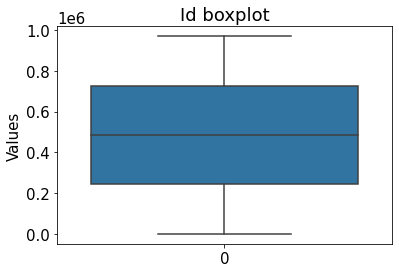

Q1 (first) quantile:  242410.75
Q2 (median) quantile:  484820.5
Q3 (third) quantile:  727230.25
100th quantile:  96964.90000000001






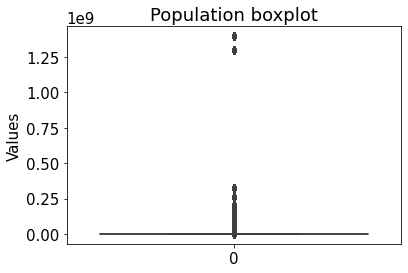

Q1 (first) quantile:  12133.0
Q2 (median) quantile:  30531.0
Q3 (third) quantile:  105612.0
100th quantile:  5399.0






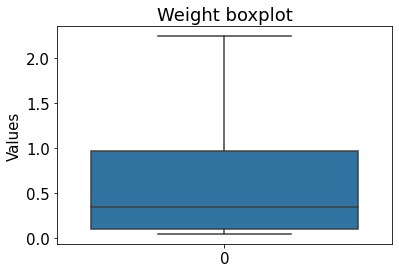

Q1 (first) quantile:  0.0968379448452679
Q2 (median) quantile:  0.34941326029484504
Q3 (third) quantile:  0.9683794484526792
100th quantile:  0.0833309781518036






In [ ]:
types = ['int64', 'float64']
boxplot_data = data_train.drop(labels=['Target', 'TargetValue'], axis=1)

for type in types:
  for column in boxplot_data.select_dtypes(include=[type]).columns:
    sns.boxplot(data=boxplot_data[column])
    plt.title(column + " boxplot")
    plt.ylabel("Values")
    plt.show()
    print("Q1 (first) quantile: ", np.quantile(boxplot_data[column], .25))
    print("Q2 (median) quantile: ", np.quantile(boxplot_data[column], .50))
    print("Q3 (third) quantile: ", np.quantile(boxplot_data[column], .75))
    print("100th quantile: ", np.quantile(boxplot_data[column], .1))
    print("\n\n\n")

##### Data distribution (TargetValue)
The distribution plot of the **TargetValue** will allow us to see how the cases and fatalities values are distributed.

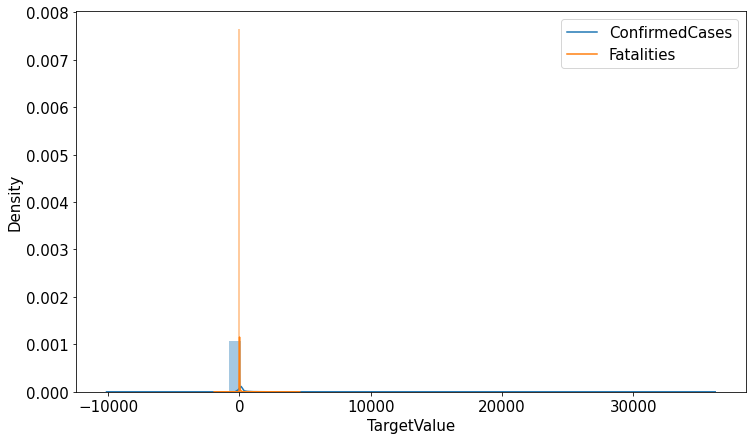

In [ ]:
plt.figure(figsize=(12,7))

labels = []
for target in data_train['Target'].unique():
  sns.distplot(data_train.loc[data_train['Target'] == target, "TargetValue"], hist=True)
  labels.append(target)

plt.legend(labels=labels, prop={"size":15})
plt.show()

##### Histogram
As `sns.displot` the histogram will tell us how the rest of the columns are distributed. The histogram will allow us to see all of the possible values in the dataset and the frequencies that they appear.

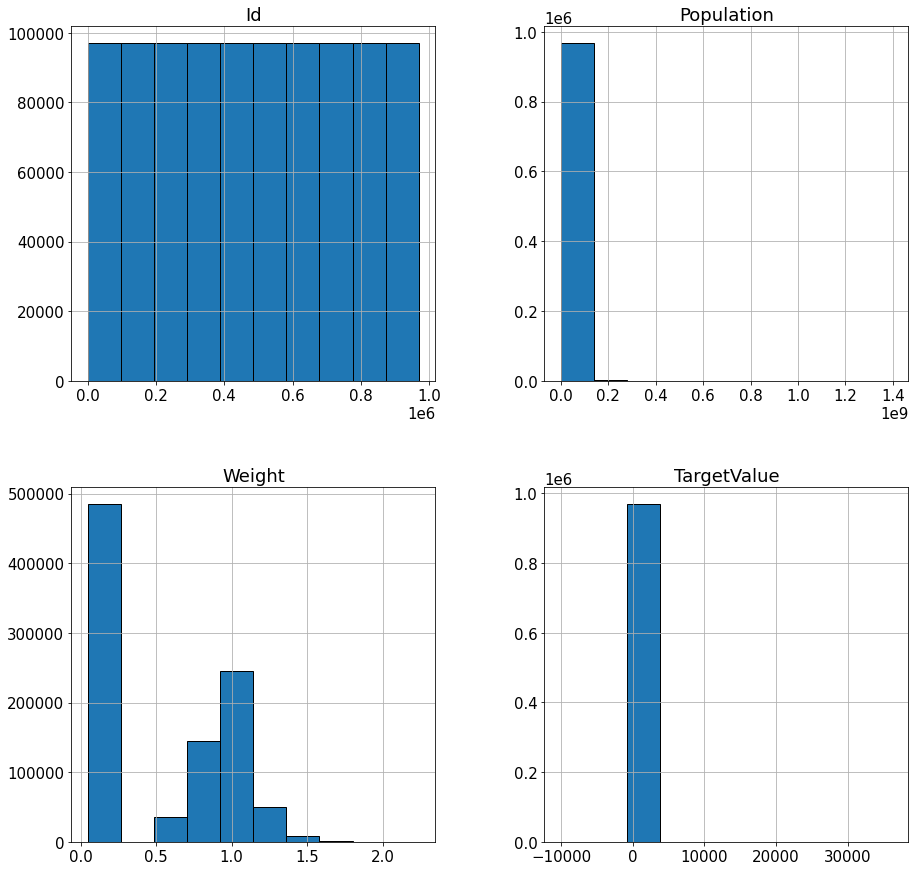

In [ ]:
data_train.hist(figsize=(15,15),edgecolor='black');

##### Heatmap
A heatmap of the values will allow us to see if there are any relationships between a pair of variables. The heatmap will allow us to see if any new columns can be formed in the dataset.

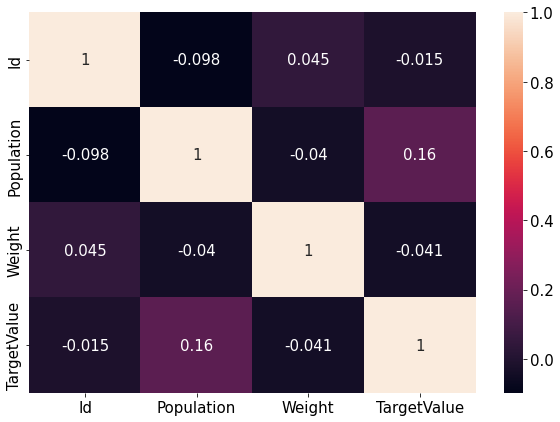

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(data_train.corr(), annot=True)
plt.show()

#### **When does the dataset take place and how long is the recorded period for?**
So far we have dealt with the missing data. But we do not know anything about the data in order for us to develop models. It is important to know the timeferame of which the data takes place in. Is it at the beginning of the pandemic or not?

In [ ]:
# Get the starting date (minimal value)
start = datetime.fromisoformat(data_train.Date.min())
# Get the last date (maximum value)
end = datetime.fromisoformat(data_train.Date.max())
# Total duration of the dataset
total = end - start

print("First date:\t{}\n" .format(start))
print("Last date:\t{}\n" .format(end))
print("Duration:\t{} days" .format(total.days))

First date:	2020-01-23 00:00:00

Last date:	2020-06-10 00:00:00

Duration:	139 days


The dataset takes place when the virus started to spread and it is recorded for 4 months and a half.

#### **Are there more confiemed cases or fatalities in the dataset?**
There are two types of **Target** values - *ConfirmedCases* and *Fatalities*. This means that the data will be split into two subsets when given to the model for more accurate results on both targets. Let's investigate if there is an equal amount of **Target** values in the dataset for each target. If there are not the same amount of rows for the **Target** we will have to use different approaches for them.

In [ ]:
# Let's see the unique targets in the dataset
data_train['Target'].unique()

array(['ConfirmedCases', 'Fatalities'], dtype=object)

% of Confirmed Cases:	50.0
% of Fatalities:	50.0



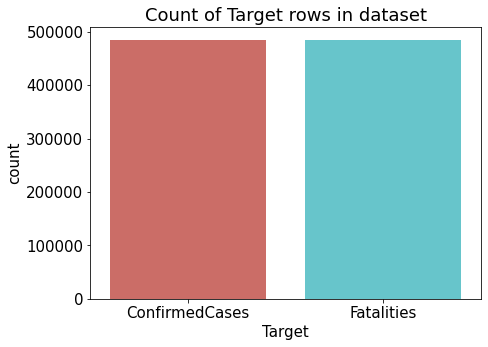

In [ ]:
# Get the total number of fatalities rows
fatalities = len(data_train['Target'] == "ConfirmedCases")
# Get the total number of confirmed cases rows
confirmed_cases = len(data_train['Target'] == "Fatalities")

print("% of Confirmed Cases:\t{}" .format(round((confirmed_cases / (confirmed_cases + fatalities) * 100), 2)))
print("% of Fatalities:\t{}\n" .format(round((fatalities / (confirmed_cases + fatalities) * 100), 2)))

plt.figure(figsize=(7, 5))
sns.countplot(x='Target', data = data_train, palette='hls')
plt.title("Count of Target rows in dataset")
plt.show()

Although there are an equal number of **Target**s in the dataset, we have to check if there are more people that were affected by **ConfirmedCases** or **Fatalities**.

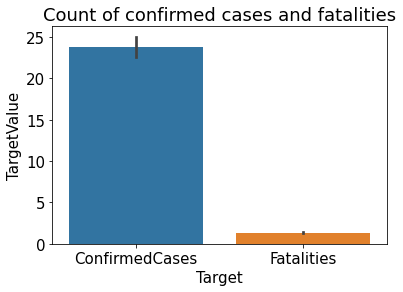

In [ ]:
sns.barplot(y= 'TargetValue', x='Target', data= data_train)
plt.title("Count of confirmed cases and fatalities")
plt.show()

The latter barplot shows that there are more confirmed cases than fatalities when they are summed up. However let's see how drastic the difference is between them in a more visually appealing way and see the percentage difference between the different **Target**s.

In [ ]:
fig = px.pie(data_train, values='TargetValue', names='Target')
fig.update_traces(textposition='inside')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

#### **Which country has the highest Target Value of fatalities and confirmed cases?**
It is certain that there are more confirmed cases than fatalities in the dataset's time period. **Country_Region** has various different countries which were affected by COVID-19. The virus could have originated in one country and the virus could have moved to one or more countries.

Because there are so many different countries, visualizing the data will become more and more difficult. We will use **Plotly** in order to visualize the data in a more interactive way.

In [ ]:
print("There are {} countries in the dataset. " .format(data_train['Country_Region'].nunique()))

There are 187 countries in the dataset. 


In [ ]:
fig = px.pie(data_train, values='TargetValue', names='Country_Region')
fig.update_traces(textposition='inside')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

Half of the dataset's confirmed cases and fatalities are from **US** and the other half are from the rest of the world. The United States of America are not the biggest country from the given list. In order for us to better understand how the virus has spread around the world, let's see every country's population compared to the number of confirmed cases and fatalities they have. <br><br>
**Note**: run `!pip install --upgrade plotly` if you get the following error message:<br>

```
fig = px.treemap(data_train, values='TargetValue', 
                 path = ['Country_Region'], color='Population', 
                 hover_data=['Country_Region'], 
                 color_continuous_scale='matter', 
                 title='Worldwide COVID-19 Confirmed Cases share')
fig.show()

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-11-0ddc80200e00> in <module>()
----> 1 fig = px.treemap(data_train, values='TargetValue', path = ['Country_Region'], color='Population', hover_data=['Country_Region'], color_continuous_scale='matter', title='Worldwide COVID-19 Confirmed Cases share')
      2 fig.show()

TypeError: treemap() got an unexpected keyword argument 'path'
```



In [ ]:
fig = px.treemap(data_train, values='TargetValue', 
                 path = ['Country_Region'], color='Population', 
                 hover_data=['Country_Region'], 
                 color_continuous_scale='matter', 
                 title='Worldwide COVID-19 Confirmed Cases and Fatalities share')
fig.show()

Although India and China have the highest populations in the dataset, they do not have the same number of cases compared to countries smaller than them such as Brazil, Russia and US.

The latter diagrams give us a quick overview of the impacted countries but viewing every country and how many cases and fatalities they have is difficult and inconvenient. Lets visualize the cases on a world map so it is easier to see how every country was affected.

In [ ]:
# Get the codes for the whole world so we can display the countries
country_codes = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
# Get only the necessary columns from the dataset - Code and Country
country_codes = country_codes[['CODE', 'COUNTRY']]
# Rename columns so they match with the COVID dataset
country_codes.rename(columns={'CODE': 'Code', 'COUNTRY': 'Country_Region'}, inplace=True)

# Fix the discrepancy countries so all of the data is displayed on the map
country_codes.loc[country_codes['Country_Region'] == 'United States', 'Country_Region'] = 'US'
country_codes.loc[country_codes['Country_Region'] == 'Congo, Democratic Republic of the', 'Country_Region'] = 'Congo (Kinshasa)'
country_codes.loc[country_codes['Country_Region'] == 'Congo, Republic of the', 'Country_Region'] = 'Congo (Brazzaville)'
country_codes.loc[country_codes['Country_Region'] == 'Macedonia', 'Country_Region'] = 'North Macedonia'
country_codes.loc[country_codes['Country_Region'] == 'Czech Republic', 'Country_Region'] = 'Czechia'

In [ ]:
# Get the TargetValue sum for every country
country_target_values = data_train.groupby('Country_Region', as_index=False)['TargetValue'].sum()
country_target_values = country_codes.merge(country_target_values)

In [ ]:
# Visualize the world map
fig = go.Figure(data=go.Choropleth(
    locations = country_target_values['Code'],
    z = country_target_values['TargetValue'],
    text = country_target_values['Country_Region'],
    colorscale = 'Reds',
    marker_line_width=0.5,
    colorbar_title = 'Cases & Fatalities',
))

fig.update_layout(
    title_text='COVID-19 Cases & Fatalities world map',
    geo=dict(
        showframe=False,
        showcoastlines=False,
    ),
    annotations = [dict(
        showarrow = False,
        text=''
    )]
)

There were issues with identifying the following countries: 
- **Somalia** - could not find correct country code
- **Kosovo** - could not find correct country code
- **Tajikistan** - could not find correct country code
- **Taiwan** - could not find correct country code
- **Greenland** - no cases in dataset
- **North Korea** - no cases in dataset
- **New Caledonia** - no cases in dataset
- **Antarctica** - no cases in dataset

As previously mentioned the **US** is the country with the highest number of cases and fatalities worldwide according to the dataset. Let's further investigate **US**.

#### **Which are the most affected States in US?**
The most affected country by COVID-19 is United States of America. However this is the only country in the dataset that has different counties based on the state. 

In [ ]:
total = data_train.shape[0]
us_total = data_train.loc[data_train['Country_Region'] == 'US'].shape[0]

print("There are {}% rows of the total dataset, which have US as their Country_Region" .format(round((us_total / total) * 100, 2)))

There are 92.35% rows of the total dataset, which have US as their Country_Region


In [ ]:
# Get the US codes from online agriculture dataset, which will be used for the US map for COVID-19 cases
us_codes = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')
us_codes = us_codes[['code', 'state']]
us_codes.rename(columns={'code':'Code', 'state':'State'}, inplace=True)

In [ ]:
# Get fatalities for every state
us_fatalities = data_train.loc[data_train['Target'] == 'Fatalities']
us_fatalities = us_fatalities.loc[data_train['Country_Region'] == 'US']
us_fatalities = us_fatalities.groupby('Province_State', as_index=False)['TargetValue'].sum()
us_fatalities.rename(columns={'Province_State':'State', 'TargetValue':'Fatalities'}, inplace=True)

# Merge the two data frames
us_data = us_codes.merge(us_fatalities)

# Fix columns for map
us_data['Fatalities'] = us_data['Fatalities'].astype(str)

# Make a new column for hover text
us_data['text'] = us_data['State'] + '<br>' + us_data['Fatalities']

fig = go.Figure(data=go.Choropleth(
    locations=us_data['Code'], # Spatial coordinates
    z = us_data['Fatalities'], # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    text=us_data['text'],
    colorscale = 'Reds',
    colorbar_title = "Fatalities",
))

fig.update_layout(
    title_text = 'USA COVID-19 Fatalities',
    geo_scope='usa', # limit map scope to USA
)

fig.show()

In [ ]:
us_fatalities.sort_values(by=['Fatalities'], ascending=False).head(6)

,State,Fatalities
33,New York,61084
44,St Martin,53805
45,Tasmania,40661
31,New Jersey,24754
22,Massachusetts,14897
46,Tennessee,14758


In [ ]:
# Get fatalities for every state
us_confiremed_cases = data_train.loc[data_train['Target'] == 'ConfirmedCases']
us_confiremed_cases = us_confiremed_cases.loc[data_train['Country_Region'] == 'US']
us_confiremed_cases = us_confiremed_cases.groupby('Province_State', as_index=False)['TargetValue'].sum()
us_confiremed_cases.rename(columns={'Province_State':'State', 'TargetValue':'Confirmed Cases'}, inplace=True)

# Merge the two data frames
us_data = us_codes.merge(us_confiremed_cases)

# Fix columns for map
us_data['Confirmed Cases'] = us_data['Confirmed Cases'].astype(str)

# Make a new column for hover text
us_data['text'] = us_data['State'] + '<br>' + us_data['Confirmed Cases']

fig = go.Figure(data=go.Choropleth(
    locations=us_data['Code'], # Spatial coordinates
    z = us_data['Confirmed Cases'], # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    text=us_data['text'],
    colorscale = 'Reds',
    colorbar_title = "Confirmed Cases",
))

fig.update_layout(
    title_text = 'USA COVID-19 Confirmed Cases',
    geo_scope='usa', # limit map scope to USA
)

fig.show()

In [ ]:
us_confiremed_cases.sort_values(by=['Confirmed Cases'], ascending=False).head(6)

,State,Confirmed Cases
46,Turks and Caicos Islands,1652806
33,New York,760312
47,Utah,371172
31,New Jersey,330481
4,California,279430
14,Illinois,259506


From both maps, we can see that different states have different number of confirmed cases and fatalities.

#### **How do COVID-19 Confirmed Cases and Fatalities increase/decrease with time?**
So far we have only looked at how the confirmed cases and fatalities are spread world wide but we have not taken into consideration how they have spread over the dataset's given timeframe. We need to find out how COVID-19 dangerous the countries are over time.

##### Confirmed cases world wide over time

In [ ]:
confirmed = data_train.loc[data_train['Target'] == 'ConfirmedCases']

countries = confirmed.groupby('Country_Region', as_index=False)['TargetValue'].sum()
trend = confirmed.groupby(['Date','Country_Region'], as_index=False)['TargetValue'].sum()
trend = trend.merge(countries, on='Country_Region')
trend.rename(columns={'Country_Region':'Country', 'TargetValue_x':'Cases'}, inplace=True)

px.line(trend, x='Date', y='Cases', color='Country', title='Confirmed cases worldwide over time')

##### Fatalities world wide over time

In [ ]:
fatalities = data_train.loc[data_train['Target'] == 'Fatalities']

countries = fatalities.groupby('Country_Region', as_index=False)['TargetValue'].sum()
trend = fatalities.groupby(['Date','Country_Region'], as_index=False)['TargetValue'].sum()
trend = trend.merge(countries, on='Country_Region')
trend.rename(columns={'Country_Region':'Country', 'TargetValue_x':'Cases'}, inplace=True)

px.line(trend, x='Date', y='Cases', color='Country', title='Fatalities worldwide over time')

Although the outburst of the virus originated from China, the US has been impacted the most world-wide. It is worth further investigating the **US** cases into more details because it has the most states and different states could have different levels of impact on cases and fatalities..

##### USA analysis

In [ ]:
usa_data = data_train.loc[data_train['Country_Region'] == 'US']

###### USA Fatalities for different states

In [ ]:
fatalities = usa_data.loc[data_train['Target'] == 'Fatalities']

countries = fatalities.groupby('Province_State', as_index=False)['TargetValue'].sum()
trend = fatalities.groupby(['Date','Province_State'], as_index=False)['TargetValue'].sum()
trend = trend.merge(countries, on='Province_State')
trend.rename(columns={'Province_State':'Province', 'TargetValue_x':'Fatalities'}, inplace=True)

px.line(trend, x='Date', y='Fatalities', color='Province', title='Fatalities in USA')

###### USA Confirmed Cases for different states

In [ ]:
comnfirmed_cases = usa_data.loc[data_train['Target'] == 'ConfirmedCases']

countries = comnfirmed_cases.groupby('Province_State', as_index=False)['TargetValue'].sum()
trend = comnfirmed_cases.groupby(['Date','Province_State'], as_index=False)['TargetValue'].sum()
trend = trend.merge(countries, on='Province_State')
trend.rename(columns={'Province_State':'Province', 'TargetValue_x':'Cases'}, inplace=True)

px.line(trend, x='Date', y='Cases', color='Province', title='Confirmed Cases in USA')

The fatalities have been going up until mid April. Afterwards they have slowly started decreasing with some upward spikes. The confirmed cases have been going up and down with some slight signs of decrease towards the end of the timeframe (June). 

On the other hand, cases in **Turks and Caicos Islands** have been going up and have barely decreased. **Utah**'s cases have had very sudden growths and then rapid decrease. **Utah**'s spikes could be a side effect from the **KNN Imputation**.

It looks like that fatalities have become less common whereas the confirmed cases remain higher over time.

##### Growth
The latter plots give us an initial insight on how many cases and fatalities there are  for each country. However let's see if the cases and fatalities are increasing or decreasing as time progresses.

In [ ]:
growth = data_train[data_train['Target'] == "ConfirmedCases"]
growth = growth.groupby('Date').sum()
growth = growth[['TargetValue']]
fig = px.line(x=growth.index, y = growth['TargetValue'], 
              title = 'Growth of number of COVID-19 cases over time', 
              labels = dict(x='Date', y = 'Number of Coivd-19 Cases'))
fig.show()

In [ ]:
growth = data_train[data_train['Target'] == "Fatalities"]
growth = growth.groupby('Date').sum()
growth = growth[['TargetValue']]
fig = px.line(x=growth.index, y = growth['TargetValue'], 
              title = 'Growth of number of COVID-19 cases over time', 
              labels = dict(x='Date', y = 'Number of Coivd-19 Cases and Fatalities'))
fig.show()

[]

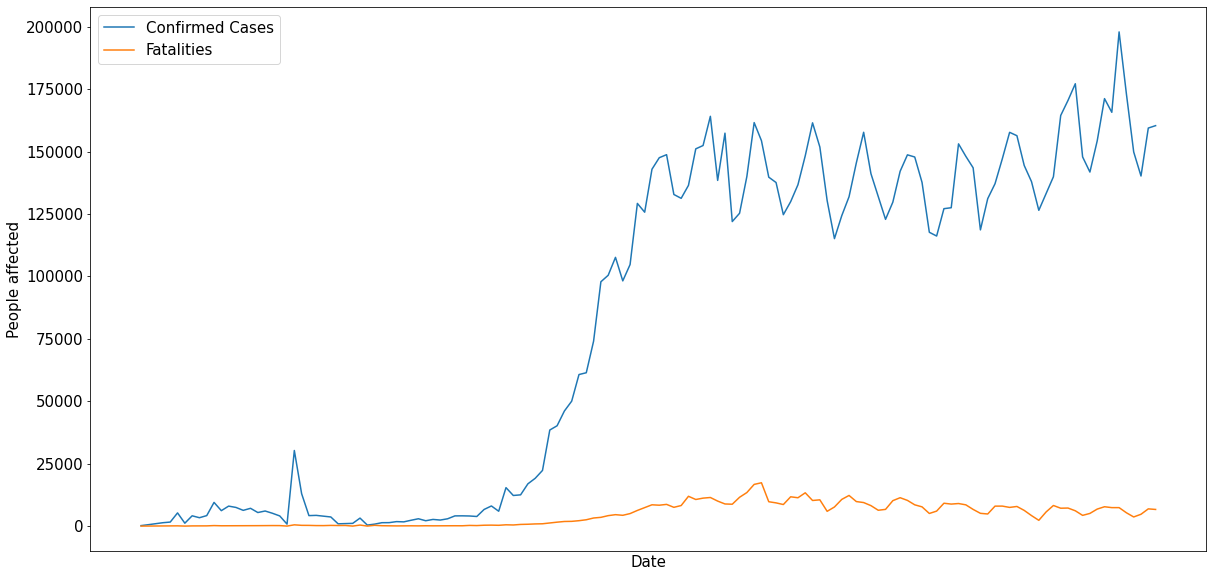

In [ ]:
plt.figure(figsize=(20,10))

growth_cases = data_train[data_train['Target'] == "ConfirmedCases"]
growth_cases = growth_cases.groupby('Date').sum()
growth_cases = growth_cases[['TargetValue']]

growth_fatalities = data_train[data_train['Target'] == "Fatalities"]
growth_fatalities = growth_fatalities.groupby('Date').sum()
growth_fatalities = growth_fatalities[['TargetValue']]

plt.plot(growth_cases.index, growth_cases['TargetValue'])
plt.plot(growth_fatalities.index, growth_fatalities['TargetValue'])

plt.legend(['Confirmed Cases', 'Fatalities'])
plt.ylabel("People affected")
plt.xlabel("Date")

plt.rcParams.update({'font.size': 15})
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.plot()

Overall worldwide cases have been growing and there are no indications of the cases going down. From the latter plots we can see that fatalities have been increasing but no where near the rate of the confirmed cases. We can conclude that the cases are going up and down in an increasing trend whereas the fatalities remain low over the whole time frame of the dataset.

#### **What is the total % of the affected population for every country?**
We have seen what the case rates are from start to finish, but let's now see what the cases/fatalities are compared to the overall population.

In [ ]:
# Get the total number of cases and fatalities
targets = data_train.groupby('Country_Region', as_index=False)['TargetValue'].sum()
# Let's rename TargetValue to Cases & Fatalities
targets = targets.rename(columns={"TargetValue": "Cases & Fatalities"})

In [ ]:
# Get the overall population for every country
population = data_train[['Country_Region', 'Population']].drop_duplicates(subset=['Country_Region'])

The population is not very accurate because some countries have province states and we will have to combine the population of those states to get the total populations.

In [ ]:
# Countries with Province_State
province_state_countries = data_train.loc[data_train['Province_State'] != 'None', 'Country_Region'].unique()

province_state_countries

array(['Australia', 'Canada', 'China', 'Denmark', 'France', 'Netherlands',
       'US', 'United Kingdom'], dtype=object)

In [ ]:
# Population of countries that need edited
population.loc[population['Country_Region'].isin(province_state_countries)]

,Country_Region,Population
2240,Australia,426709
11200,Canada,4413146
15680,China,62550000
28000,Denmark,49376
32760,France,254541
52080,Netherlands,107394
67760,US,55869
964040,United Kingdom,13452


In [ ]:
# Get the rows with a Province State 
province_state = data_train.loc[data_train['Province_State'] != 'None'].drop_duplicates(subset=['Province_State'])
province_state = province_state[['Province_State', 'Country_Region', 'Population']]
# Get the population for every country with more than one province
province_state_population = province_state.groupby('Country_Region', as_index=False)['Population'].sum()
province_state_population

,Country_Region,Population
0,Australia,101438648
1,Canada,151401680
2,China,2791546800
3,Denmark,105223
4,France,2425070
5,Netherlands,317892
6,US,334460329
7,United Kingdom,459067


In [ ]:
population.loc[population['Country_Region'].isin(province_state_countries), 'Country_Region'].unique()

array(['Australia', 'Canada', 'China', 'Denmark', 'France', 'Netherlands',
       'US', 'United Kingdom'], dtype=object)

In [ ]:
# Set the population for the outstanding countries
for country in province_state_countries:
  population.loc[population['Country_Region'] == country, 'Population'] = province_state_population.loc[province_state_population['Country_Region'] == country, 'Population'].values

Now we can calculate the **Impacted %** of the population. This can be done by the following formula:<br> <br>

\begin{align}
Impacted = \frac{Cases \& Fatalities}{Population}
\end{align}

In [ ]:
# Create a new dataframe which will have the % of the affected population
affected = population.merge(targets)
# Calculate the impacted population
affected['Impacted %'] = round((affected['Cases & Fatalities'] / affected['Population']) * 100, 3)

In [ ]:
# Sort the values by impacted rate
affected.sort_values(by=['Impacted %'], ascending=False).head(15)

,Country_Region,Population,Cases & Fatalities,Impacted %
177,United Kingdom,459067,332801,72.495
48,Diamond Princess,3711,725,19.537
121,Netherlands,317892,54355,17.099
47,Denmark,105223,12809,12.173
62,France,2425070,221390,9.129
137,Qatar,2587564,73661,2.847
75,Holy See,451,12,2.661
144,San Marino,33005,733,2.221
173,US,334460329,6317214,1.889
3,Andorra,78014,903,1.157


Based on the sorted **Impacted %** values, there are countries (the top 5 countries) that do not have the whole population. Aside from that there are not that many impacted people world wide aside from the **Diamond Prinecss**, which is actually a cruise ship and not a country.

#### **Is the Population affected by TargetValue == Fatalities?**
The meaning of fatality is: <br>
*an occurrence of death by accident, in war, or from disease* <br><br>
When there is a fatality, does the population decrease or stay the same? This will give us insight if the population decreases with time. Let's display the countries where the `min` and `max` populations do not match.

In [ ]:
fatalities = data_train.loc[data_train['Target'] == "Fatalities"]
fatalities = fatalities[fatalities['TargetValue'] > 0]

for country in fatalities['Country_Region'].unique():
  min = fatalities.loc[fatalities['Country_Region'] == country, 'Population'].min()
  max = fatalities.loc[fatalities['Country_Region'] == country, 'Population'].max()
  # Display countries where the minimum and maximum values do not match
  if min != max:
    print("\nCountry:\t{}\n" .format(country))
    print("Min population:\t{}\n" .format(min))
    print("Max population:\t{}\n" .format(max))
    print("_" * 40)


Country:	Australia

Min population:	426709

Max population:	25359662

________________________________________

Country:	Canada

Min population:	158158

Max population:	37850420

________________________________________

Country:	China

Min population:	7324300

Max population:	1395773400

________________________________________

Country:	France

Min population:	36979

Max population:	66710000

________________________________________

Country:	Netherlands

Min population:	38247

Max population:	17019800

________________________________________

Country:	US

Min population:	1398

Max population:	324141489

________________________________________

Country:	United Kingdom

Min population:	4922

Max population:	65110000

________________________________________


The latter countries have a different population because they are the same countries which were an exception in the **'*What is the total % of the affected population for every country?*'** section. they have different provinces which have different populations. Let's further investigate these countries and their populations.

In [ ]:
print("Countries with provinces:\n\n{}" .format(province_state_countries))

Countries with provinces:

['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


We will ignore **US** in the following code because it's population is also affected by different counties. We will focus on countries that do not have counties for now.

In [ ]:
# Get the countries that are only in the province_state_countries
fatalities = fatalities.loc[fatalities['Country_Region'].isin(province_state_countries)]

# Go over every province and check if the values match
for country in fatalities['Country_Region'].unique():
  for province in fatalities.loc[fatalities['Country_Region'] == country, 'Province_State'].unique():
    temp = fatalities.loc[fatalities['Country_Region'] == country]
    temp = temp.loc[temp['Province_State'] == province]
    
    min = temp['Population'].min()
    max = temp['Population'].max()

    # Do min and max values match?
    if min != max and country != 'US':
      print("\nCountry:\t{} - {}\n" .format(country, province))
      print("Counties:\n{}\n" .format(temp['County'].unique()))
      print("Min population:\t{}\n" .format(min))
      print("Max population:\t{}\n" .format(max))

      print("_" * 40)


Country:	Australia - New South Wales

Counties:
['None']

Min population:	8089526

Max population:	25359662

________________________________________

Country:	Canada - New Brunswick

Counties:
['None']

Min population:	779993

Max population:	37850420

________________________________________


It seems that none of the countries' provinces have a difference in the `min` and `max` population. this means that the population does not change at all.

To be on the safe side, let's check if the following equation is met in the dataset:<br>

$$min = max - fatalities$$

$min$ - minimum number of population

$max$ - maximum number of population

$fatalities$ - the number of fatalities for that country

If the equation is met then the data is correctly labelled. Otherwise the data's population is not impacted by the number of fatalities per day for the countries. For United States of America we will also have to go through every county because different counties have different populations. This is not the case for the other countries (non **US**)

In [ ]:
# Go over every province and check if the values match
for country in fatalities['Country_Region'].unique():
  for province in fatalities.loc[fatalities['Country_Region'] == country, 'Province_State'].unique():
    temp = fatalities.loc[fatalities['Country_Region'] == country]
    temp = temp.loc[fatalities['Province_State'] == province]
    
    min = temp['Population'].min()
    max = temp['Population'].max()
    total_fatalities = temp['TargetValue'].sum()

    if country != 'US':
      # Is the minimum value based on the total number of fatalities?
      if min == max - total_fatalities:
        print("\nCountry:\t{} - {}\n" .format(country, province))
        print("Min population:\t{}\n" .format(min))
        print("Max population:\t{}\n" .format(max))
        print("Total Fatalities:\t{}\n" .format(total_fatalities))
        print("_" * 40)
    # Check if there are population issues with the County in every US state
    else:
      for county in temp['County'].unique():
        temp_county = temp.loc[temp['County'] == county]
        min = temp_county['Population'].min()
        max = temp_county['Population'].max()
        total_fatalities = temp_county['TargetValue'].sum()

        if min == max - total_fatalities:
          print("\nCountry:\t{} - {} - {}}\n" .format(country, province, county))
          print("Min population:\t{}\n" .format(min))
          print("Max population:\t{}\n" .format(max))
          print("Total Fatalities:\t{}\n" .format(total_fatalities))
          print("_" * 40)

Overall the population does not decrease given the number of fatalities for any of the countries. However we found that there is data inconsistencies in the data which we will deal with. The column **Population** suggests that it measures the overall population of the country rather than the current population (including the mortalities).

#### **How many people survived COVID-19?**
If we know the confirmed cases and fatalities per day, then the number of survivors can be calculated.

In [ ]:
# Calculate the total number of cases - worldwide
total_cases = data_train.loc[data_train['Target'] == 'ConfirmedCases']
total_cases = total_cases['TargetValue'].sum()
print("Total world cases: {}\n" .format(total_cases))

# Calculate the total number of cases - worldwide
total_fatalities = data_train.loc[data_train['Target'] == 'Fatalities']
total_fatalities = total_fatalities['TargetValue'].sum()
print("Total world fatalities: {}" .format(total_fatalities))

Total world cases: 11528819

Total world fatalities: 653271


A person that has COVID-19 is considered to be a confirmed case, however if they die it is considered a fatality. The survivors can be calculated the following way: <br>
$survivors = cases - fatalities$

In [ ]:
survivors = total_cases - total_fatalities
survivors_percent = round((survivors / total_cases) * 100, 2)

print("Total world survivors: {} ({}%)" .format(survivors, survivors_percent))

Total world survivors: 10875548 (94.33%)


In [ ]:
total_cases = data_train.loc[data_train['Target'] == 'ConfirmedCases']
total_cases = total_cases.groupby(['Date'], as_index=False)['TargetValue'].sum()
total_cases = total_cases.rename(columns={"TargetValue": "Confirmed Cases"})

total_fatalities = data_train.loc[data_train['Target'] == 'Fatalities']
total_fatalities = total_fatalities.groupby(['Date'], as_index=False)['TargetValue'].sum()
total_fatalities = total_fatalities.rename(columns={"TargetValue": "Fatalities"})

info = total_cases.merge(total_fatalities)
info['Survivors'] = info['Confirmed Cases'] - info['Fatalities']

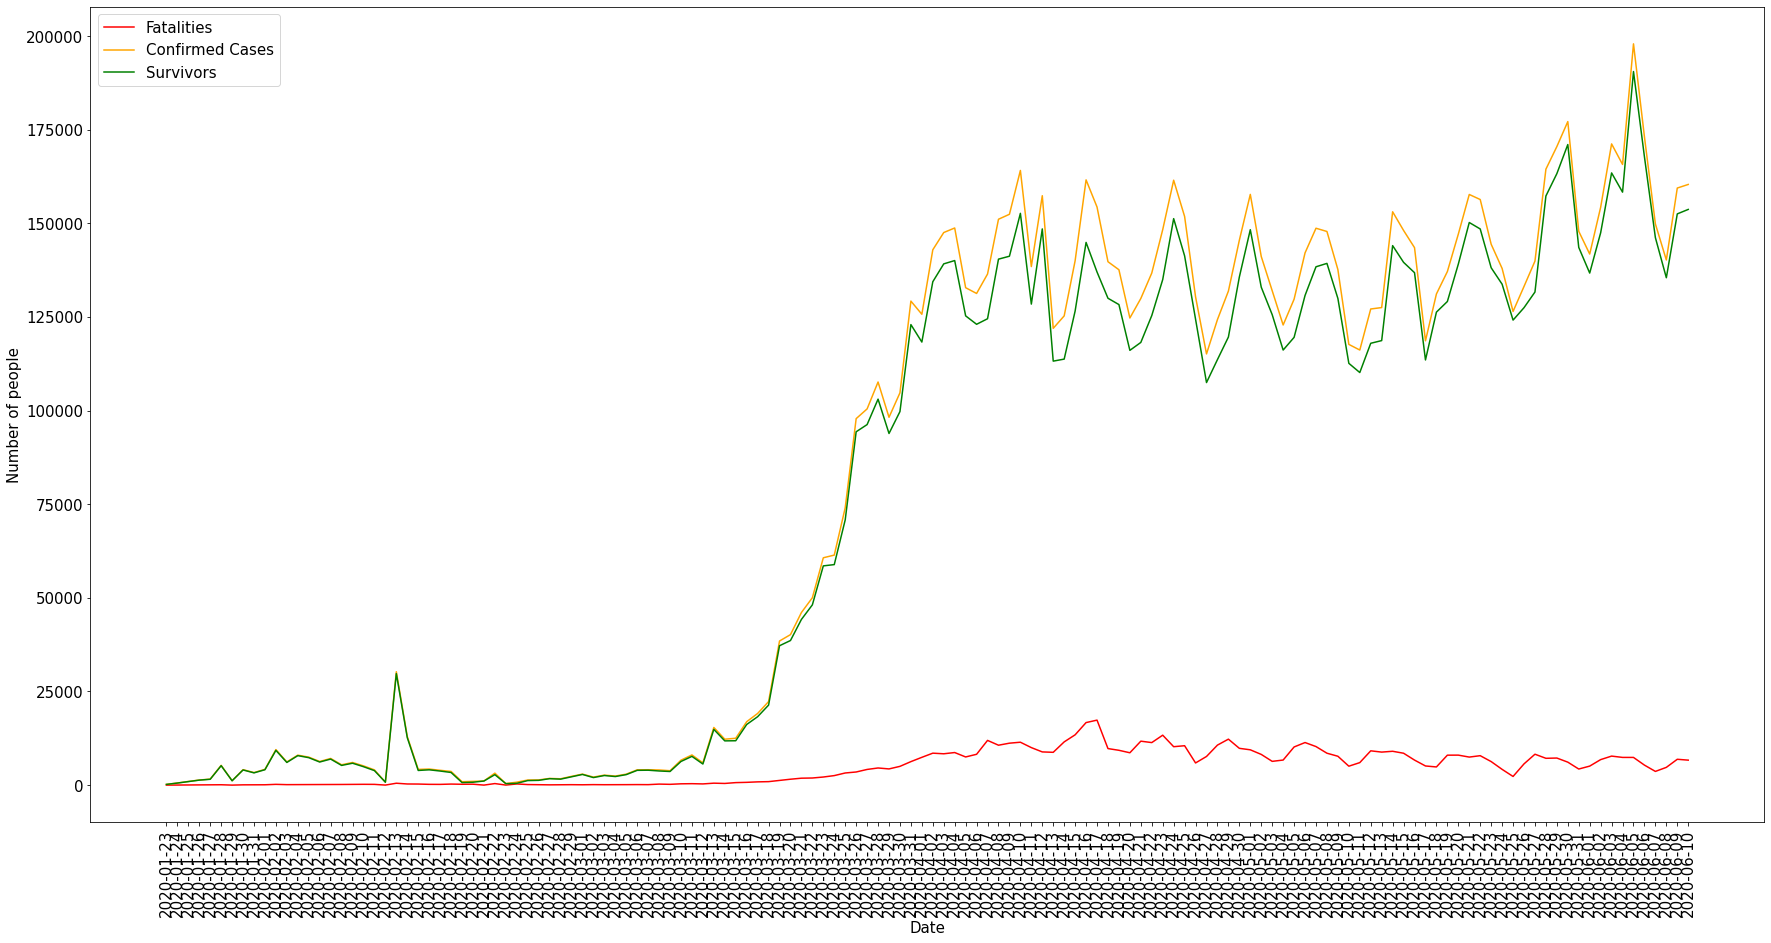

In [ ]:
# Display the fatalities, confirmed cases and survivors
plt.figure(figsize=(30,15))
# Fatalities
plt.plot(info['Date'], info['Fatalities'], 'red', label='Fatalities')
# Confirmed Cases
plt.plot(info['Date'], info['Confirmed Cases'], 'orange', label='Confirmed Cases')
# Survivors
plt.plot(info['Date'], info['Survivors'], 'green', label='Survivors')
plt.xticks(rotation=90)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Number of people")
plt.show()

Majority of the cases have survived COVID-19 from all of the affected people worldwide.

## Data Preparation
Before we give the data to the machine learning models, we have to find a way to prepare the data into numbers that can help us predict, in order to make predictions and make them as accurate as possible. 

### Data inconsistencies
By visualizing the data, now we can investigate if the data is inconsistent and if it how it can be fixed. Data inconsistencies can have an impact on the model's final predictions.

#### **Are there any inconsistent target values?**
Let's check if there are any negative **ConfirmedCases** or **Fatalities**. Negative values do not make any logical sense and will be replaced with 0s.

In [ ]:
print("Rows with negative TargetValue: {}" .format(data_train.loc[data_train['TargetValue'] < 0].shape[0]))

Rows with negative TargetValue: 4587


In [ ]:
data_train.loc[data_train['TargetValue'] < 0, 'TargetValue'] = 0
print("Rows with negative TargetValue after the update: {}" .format(data_train.loc[data_train['TargetValue'] < 0].shape[0]))

Rows with negative TargetValue after the update: 0


#### **Are there any inconsistencies with the population?**
From the ***Is the Population affected by TargetValue == Fatalities?*** question we saw that there were places with an inconsistent population. Let's update the population for those places.

First, let's see which were the countries that need to be updated. **US** was an exception because it is the only country in the dataset that has a county that is not **None**. 

The minimum and maximum population are very different from each other. Let's further investigate and see the weight for the minimum and maximum values.

In [ ]:
# Get the countries that are only in the province_state_countries
fatalities = fatalities.loc[fatalities['Country_Region'].isin(province_state_countries)]

# Go over every province and check if the values match
for country in fatalities['Country_Region'].unique():
  for province in fatalities.loc[fatalities['Country_Region'] == country, 'Province_State'].unique():
    temp = fatalities.loc[fatalities['Country_Region'] == country]
    temp = temp.loc[temp['Province_State'] == province]
    
    min = temp['Population'].min()
    min_weight = temp.loc[temp['Population'] == min, 'Weight'].min()
    max = temp['Population'].max()
    max_weight = temp.loc[temp['Population'] == max, 'Weight'].max()

    # Do min and max values match?
    if min != max and country != 'US':
      print("\nCountry:\t{} - {}\n" .format(country, province))
      print("Counties:\n{}\n" .format(temp['County'].unique()))

      print("Min population:\t{}\n" .format(min))
      print("Min weight:\t{}\n" .format(min_weight))

      print("Max population:\t{}\n" .format(max))
      print("Max weight:\t{}\n" .format(max_weight))

      print("_" * 40)


Country:	Australia - New South Wales

Counties:
['None']

Min population:	8089526

Min weight:	0.6286903803088131

Max population:	25359662

Max weight:	0.5865560050186087

________________________________________

Country:	Canada - New Brunswick

Counties:
['None']

Min population:	779993

Min weight:	0.7370803719687442

Max population:	37850420

Max weight:	0.5730937309384314

________________________________________


The weight is different for both `min` and `max` population and their weights as well. We will update the weights so the data is consistent.

In [ ]:
# Get the countries that are only in the province_state_countries
fatalities = fatalities.loc[fatalities['Country_Region'].isin(province_state_countries)]

# Go over every province and check if the values match
for country in fatalities['Country_Region'].unique():
  for province in fatalities.loc[fatalities['Country_Region'] == country, 'Province_State'].unique():
    temp = data_train.loc[data_train['Country_Region'] == country]
    temp = temp.loc[temp['Province_State'] == province]
    
    min = temp['Population'].min()
    min_weight = temp.loc[temp['Population'] == min, 'Weight'].min()
    max = temp['Population'].max()
    max_weight = temp.loc[temp['Population'] == max, 'Weight'].max()

    # Do min and max values match?
    if min != max and country != 'US':
      data_train.loc[data_train['Country_Region'].str.contains(country) & data_train['Province_State'].str.contains(province), 'Population'] = min
      data_train.loc[data_train['Country_Region'].str.contains(country) & data_train['Province_State'].str.contains(province), 'Weight'] = min_weight

### Cases and Fatalities
So far we have explored the data no matter if the **Target** is *ConfirmedCases* or *Fatalities*. Now we will split the data and feed it like this to the machine learning models. The data is seperated in two types based on the **Target** - **Fatalities** and **ConfirmedCases**.

In [ ]:
data_fatalities = data_train.loc[data_train['Target'] == 'Fatalities']
data_cases = data_train.loc[data_train['Target'] == 'ConfirmedCases']

Now that the data is split in two smaller datasets, we can remove the **Target** columm because it does not contribute anything to the predictions. The column was used to distinguish the two different types of data - **Fatalities** and **ConfirmedCases**.

In [ ]:
data_fatalities = data_fatalities.drop(labels=['Target'], axis=1)
data_cases = data_cases.drop(labels=['Target'], axis=1)

### Date column
The date is very important for the data because it is the timestamp of the dataset. At the moment **Date** is an **Object**. We will convert the dates to integer values. Instead of making a new column for the day, month and year from the **Date** column, we will convert the date to a numeric value. For example the first day of the pandemic (2020-01-23) would be day 1 in the dataset and so on.

In [ ]:
# Convert the Date column (object) to integer values
def createDays(df, id_column = 'Id', date_column = 'Date'):
  df[id_column] = data_train.index
  no_train = data_train[id_column].nunique()
  train_days = data_train[date_column].nunique()
  datet = data_train[date_column]
  lotrain = int(no_train / train_days)

  zt = datet[0]
  day_count = []

  # The dataset is split into confirmed cases and fatalities => split the variable in 2 targets
  lt = int(lotrain/2)

  for i in range(0,lt):
      for j in range(1,train_days+1):
          day_count.append(j)

  return day_count

In [ ]:
# Get the day counting 
day_count = createDays(data_train)

# Insert day column in Fatalities dataset
data_fatalities.insert(5, 'DayCount', day_count)
# Remove ID column
data_fatalities = data_fatalities.drop(labels=['Id'], axis=1)

# Insert day column in Cases dataset
data_cases.insert(5, 'DayCount', day_count)
# Remove ID column
data_cases = data_cases.drop(labels=['Id'], axis=1)

# Drop the original Date column from both datasets
data_fatalities = data_fatalities.drop(labels=['Date'], axis=1)
data_cases = data_cases.drop(labels=['Date'], axis=1)

### SIR model
One way to see the COVID-19 spread is by using the susceptible-infected-recovered (**SIR**) model. It is used to model infectious diseases and how they spread. In our case we will use the **SIR** model for the world population to see how it has spread.

In [ ]:
def sir(y,t,b,c,d):
    susceptible = -b * y[0] * y[1] / susceptible_0
    recovered = c * y[1]
    fatalities = d * y[1]
    infected = -(susceptible + recovered + fatalities)
    return susceptible, infected, recovered, fatalities

def inf_odeint(t,b,c,d):
    return integrate.odeint(sir,(susceptible_0,infected_0,0,0),t,args=(b,c,d))[:,1]

In [ ]:
# Get the total world population
population = data_cases.loc[data_cases['DayCount'] == 1, 'Population'].sum()
# Get the Y (Target Value)
y_arr = np.array(data_cases.groupby('DayCount').sum()['TargetValue'])
# Get all all days (from start to finish)
t_arr = data_cases['DayCount'].unique()

susceptible_0 = population - y_arr[0]
infected_0 = y_arr[0]

popt, pcov = optimize.curve_fit(inf_odeint, t_arr, y_arr)
fitted_cases = inf_odeint(t_arr, *popt)

In [ ]:
# Get the total world population
population = data_fatalities.loc[data_fatalities['DayCount'] == 1, 'Population'].sum()
# Get the Y (Target Value)
y_arr = np.array(data_fatalities.groupby('DayCount').sum()['TargetValue'])
# Get all all days (from start to finish)
t_arr = data_fatalities['DayCount'].unique()

susceptible_0 = population - y_arr[0]
infected_0 = y_arr[0]

popt, pcov = optimize.curve_fit(inf_odeint, t_arr, y_arr)
fitted_fatalities = inf_odeint(t_arr, *popt)

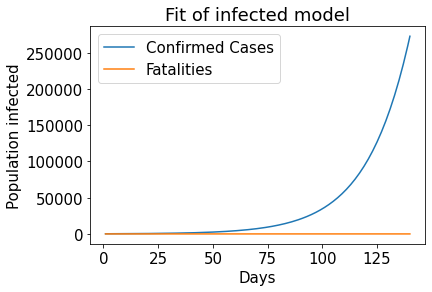

In [ ]:
plt.plot(t_arr, fitted_cases)
plt.plot(t_arr, fitted_fatalities)

plt.title("Fit of infected model")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.legend(["Confirmed Cases", "Fatalities"])
plt.show()

From the **SIR** model we can see that from Day 75 the **Confirmed Cases** start increasing exponentially, whereas the deaths remain low without any increase/decrease. However we will not be using the **SIR** model to make the predictions because there will not be enough data for the models to learn - there are 140 days in the dataset and it will not be enough to correctly train the algorithms or even split the data

### Labels to numbers
So far we have dealt with **Date**, however, in order to feed the data to the algorithms, we need to converge the labels - **County**, **Province_State** and **Country_Region**. We will use `le_dictionary` that was previously used in the **KNN Imputation** section.

We will make two helper functions - one that encodes the labels to numbers (`covertLabels`) and another one that converts the numbers to labels (`revertLabels`).

In [ ]:
# Convert the labels to numbers
def convertLabels(original_data, dictionary):
  data = original_data.copy()

  # Go over every column except target
  for column in dictionary.keys():
    if column != 'Target':
      # encode the current column
      data[column] = dictionary[column].fit_transform(data[column])

  return data

In [ ]:
# Convert the numbers to labels
def revertLabels(original_data, dictionary):
  data = original_data.copy()
  # Go over every column except target
  for column in dictionary.keys():
    if column != 'Target':
      # revert the current column's encoding
      data[column] = dictionary[column].inverse_transform(data[column])

  return data

In [ ]:
# The only label that we will not use in the le_dictionary is Target - it was initially removed
data_cases = convertLabels(data_cases, le_dictionary)
data_fatalities = convertLabels(data_fatalities, le_dictionary)

### Feature selection
In order to get a better idea of which features are more important than others for the machine learning models, we will run `RandomForestClassifier`.

In [ ]:
# Run RandomForestClassifier on the data and return the most important features of the dataset
def featureSelection(data):
  x = data.drop(labels=['TargetValue'], axis=1)
  y = data['TargetValue']

  # max_depth is set to 10 to avoid RAM problems
  sel = SelectFromModel(RandomForestClassifier(n_estimators=100, max_depth=10))
  sel.fit(x, y)

  columns = sel.get_support()

  # Append the TargetValue column
  columns = np.append(columns, True)

  print("Columns to be removed from: {}\n" .format(data.loc[:, ~columns].columns.values))
  print("Columns to be kept: {}" .format(data.loc[:, columns].columns.values))

  # Return True columns and data
  return data.loc[:, columns]

In [ ]:
print("Confirmed Cases:\n")
data_cases = featureSelection(data_cases)

print("\nFatalities:\n")
data_fatalities = featureSelection(data_fatalities)

Confirmed Cases:

Columns to be removed from: ['County' 'Province_State' 'Country_Region']

Columns to be kept: ['Population' 'DayCount' 'Weight' 'TargetValue']

Fatalities:

Columns to be removed from: ['County' 'Province_State' 'Country_Region']

Columns to be kept: ['Population' 'DayCount' 'Weight' 'TargetValue']


### Data split
The data does not have any `NaN` values and has been split into **ConfirmedCases** and **Fatalities**. We have also encoded all of the `object` data fields to numbers and now we can split the data into training and testing. The dataset is based on time series and it should not be split randomly because individual data points are not independent. Instead the data should be split along a sequence. 

Let's double check that both `data_cases` and `data_fatalities` have the same shape. If they do, we can use one set of variables to split the data rather than individual variables for both data sets.

In [ ]:
if data_cases.shape == data_fatalities.shape:
  print("The datasets have the same shape. We can use 1 set of variables when splitting the data.")
else:
  print("The datasets do not have the same shape. We will have to split them in a different way.")

The datasets have the same shape. We can use 1 set of variables when splitting the data.


`data_cases` and `data_fatalities` are the same size. Now let's sort them by **DayCount** before we split the data.

Now that we can split the data in the following way:
1. **train** - used to learn the parameters of the model.
2. **validate** - used to measure how accurately the model predicts data.
3. **test** - used as a proxy for unseen data and evaluate how the model is doing on the test set.

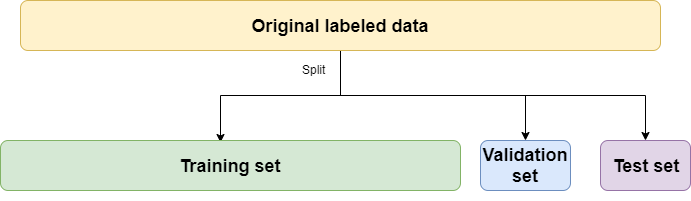

The dev and test set should be big enough to represent accurately the performance of the model. Both `data_cases` and `data_fatalities` have nearly half a million examples each and the data is big enough to be split into three parts to get better performance measures. However if the dataset was significantly smaller, we would use the old school method - train / test split.

In order to get the most out of the data and train the models, we will split the data in the following way: 
1. **train** - 85% of the dataset
2. **validate** - 7.5% of the dataset
3. **test** - 7.5% of the dataset

The data will be split based on **DayCount** because the dataset consists of a time series. We cannot use **Country_Region** to split the data because the data will not be from the same distribution.

First, let's start with distributing the days for train, dev and test.

In [ ]:
# Get the biggest DayCount value
total_days = data_cases['DayCount'].max()
# Get the smallest DayCount value
first_day = data_cases['DayCount'].min()

print("The dataset takes place in a {} days timeframe:\n" .format(total_days))

# Get train days
train_days = int(round(data_cases['DayCount'].max() * 0.85))
print("1. The train set will take place between day {} and day {}.\n" .format(first_day, train_days))

# Get dev days
dev_days = int(round((total_days - train_days) * 0.5))
print("2. The validation set will take place between day {} and day {}.\n" .format(train_days + 1, train_days + dev_days))

# Get test days
test_days = int(round((total_days - train_days - dev_days)))
print("3. The test set will take place between day {} and day {}." .format(train_days + dev_days + 1, total_days))

The dataset takes place in a 140 days timeframe:

1. The train set will take place between day 1 and day 119.

2. The validation set will take place between day 120 and day 129.

3. The test set will take place between day 130 and day 140.


Now we can split the data into train, dev and test.

In [ ]:
"""
Plot the train, dev and test data to see how they are split in the dataset
Parameters:
  - data - the entire dataset. Used to plot all of the datapoints
  - dev - the dev dataset
  - test - the test dataset
"""
def plotData(data, dev, test, type):
  temp_data = data.groupby('DayCount', as_index=False)['TargetValue'].sum()
  temp_dev = dev.groupby('DayCount', as_index=False)['TargetValue'].sum()
  temp_test = test.groupby('DayCount', as_index=False)['TargetValue'].sum()

  plt.figure(figsize=(20,10))
  plt.xlabel("Days")
  plt.ylabel(type)
  plt.plot(temp_data['DayCount'], temp_data['TargetValue'], "o-")
  plt.plot(temp_dev['DayCount'], temp_dev['TargetValue'], "o-")
  plt.plot(temp_test['DayCount'], temp_test['TargetValue'], "o-")

  plt.legend(['Train', 'Validate', 'Test'])
  plt.show()

#### Confirmed Cases

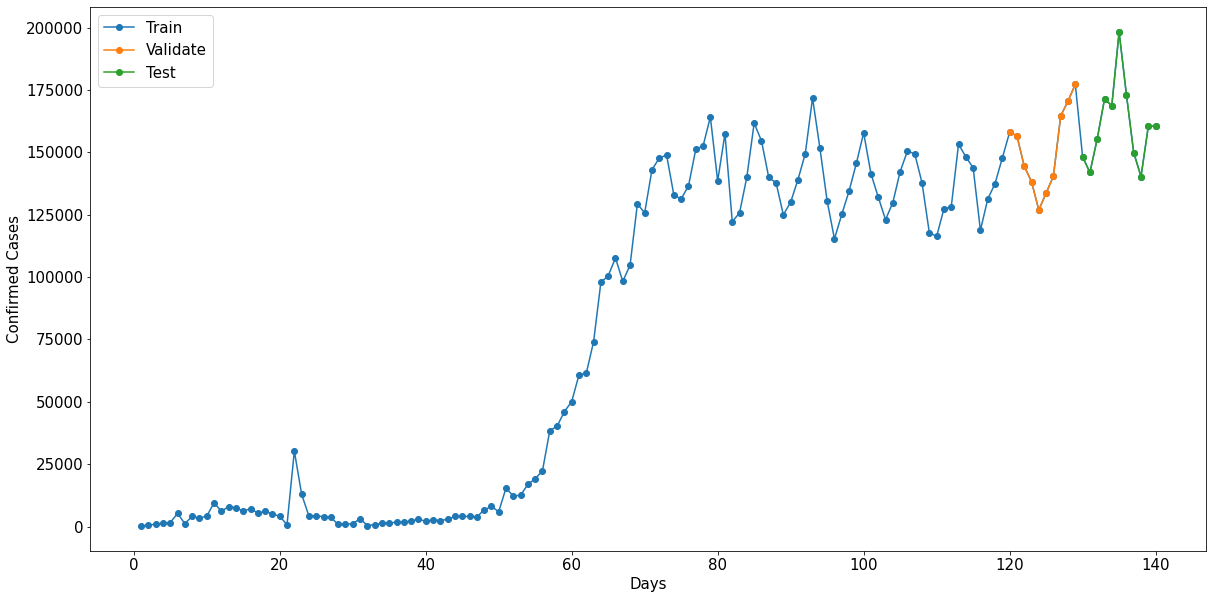

In [ ]:
# Train set
data_cases_train = data_cases.loc[data_cases['DayCount'] <= train_days]

# Dev set
data_cases_dev = data_cases.loc[(data_cases['DayCount'] >= train_days + 1) & (data_cases['DayCount'] <= train_days + dev_days)]

# Test set
data_cases_test = data_cases.loc[(data_cases['DayCount'] >= train_days + dev_days + 1) & (data_cases['DayCount'] <= total_days)]

cases_split_length = data_cases_train.shape[0] + data_cases_dev.shape[0] + data_cases_test.shape[0]

# Check if any data has been lost in the split
if (cases_split_length == data_cases.shape[0]):
  # Plot the data split
  plotData(data_cases, data_cases_dev, data_cases_test, "Confirmed Cases")

  # Save the split data - uncomment if you do not have the data
  # data_cases_train.to_csv(path + "Confirmed Cases/train_data.csv", index=False)
  # data_cases_dev.to_csv(path + "Confirmed Cases/validate_data.csv", index=False)
  # data_cases_test.to_csv(path + "Confirmed Cases/test_data.csv", index=False)
else:
  print("{} data points has been lost in the train / dev / test split." .format(data_cases.shape[0] - cases_split_length))

#### Fatalities

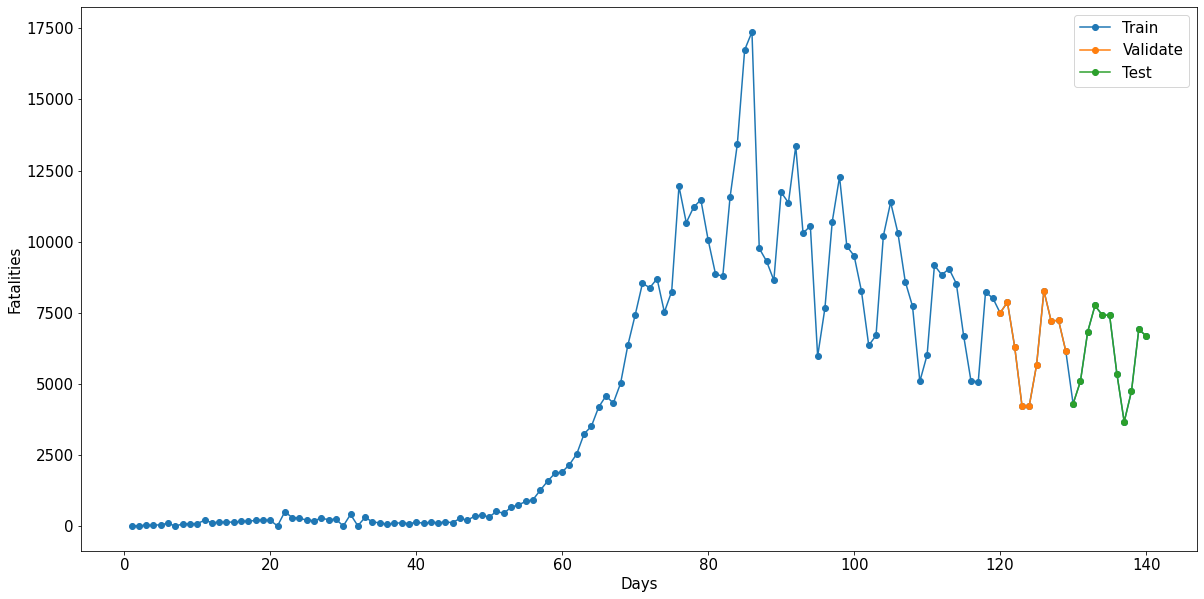

In [ ]:
# Train set
data_fatalities_train = data_fatalities.loc[data_fatalities['DayCount'] <= train_days]

# Dev set
data_fatalities_dev = data_fatalities.loc[(data_fatalities['DayCount'] >= train_days + 1) & (data_fatalities['DayCount'] <= train_days + dev_days)]

# Test set
data_fatalities_test = data_fatalities.loc[(data_fatalities['DayCount'] >= train_days + dev_days + 1) & (data_fatalities['DayCount'] <= total_days)]

cases_split_length = data_fatalities_train.shape[0] + data_fatalities_dev.shape[0] + data_fatalities_test.shape[0]

# Check if any data has been lost in the split
if (cases_split_length == data_fatalities.shape[0]):
  # Plot the data split
  plotData(data_fatalities, data_fatalities_dev, data_fatalities_test, "Fatalities")

  # Save the split data - uncomment if you do not have the data
  # data_fatalities_train.to_csv(path + "Fatalities/train_data.csv", index=False)
  # data_fatalities_dev.to_csv(path + "Fatalities/validate_data.csv", index=False)
  # data_fatalities_test.to_csv(path + "Fatalities/test_data.csv", index=False)
else:
  print("{} data points has been lost in the train / dev / test split." .format(data_fatalities.shape[0] - cases_split_length))

## Models
The missing data has been dealt with and the data has been prepared for the machine learning models. In this section we explore which algorithms best predict.

First, let's load the train, dev and test data, which was designed in the **Data Preparation** section.

In [ ]:
# Load confirmed cases train/dev/test data
data_cases_train = pd.read_csv(path + "Confirmed Cases/train_data.csv")
data_cases_validate = pd.read_csv(path + "Confirmed Cases/validate_data.csv")
data_cases_test = pd.read_csv(path + "Confirmed Cases/test_data.csv")

# Load fatalities train/dev/test data
data_fatalities_train = pd.read_csv(path + "Fatalities/train_data.csv")
data_fatalities_validate = pd.read_csv(path + "Fatalities/validate_data.csv")
data_fatalities_test = pd.read_csv(path + "Fatalities/test_data.csv")

### Metrics
In order to train the model correctly, we will have to evaluate how well the predictions are compared to the actual values. For regression the predicted value has to be as close to the actual prediction, making the error between the values as small as possible. On the other side, a bigger error means that the model is less accurate.

One of the most common ways of evaluating the accuracy of a forecasting model is by using **Mean Squared Error**. **MSE** is the average of the squared difference between the true value and predicted value in the dataset. It also measures the variance of the residuals. This metric will give us a clear idea of how well the algorithms predict.

We will also use the [Kaggle suggested evaluation metric - *Weighted Pinball Loss*](https://www.kaggle.com/c/covid19-global-forecasting-week-5/overview/evaluation) to evaluate how well the algorithm is modelling the data as a secondary supportive method.

$𝐿𝜏(𝑦,𝑦̂ )=(𝑦−𝑦̂ )𝜏$&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;if $𝑦 ≥ 𝑦̂ $

&emsp;&emsp;&emsp;&emsp;&emsp;$= (𝑦̂ −𝑦)(1−𝜏)$&emsp;&emsp;if $𝑦̂ > 𝑦$
<br><br>
Where: 
- **τ** is the quantile
- **𝑦** is the real target value 
- **𝑦̂** is the prediction

The function is always positive and the further away from the target 𝑦 value, the larger the value of **𝐿𝜏(𝑦,𝑦̂)** is. The slope is used to reflect the desired imbalance in the quantile forecast.

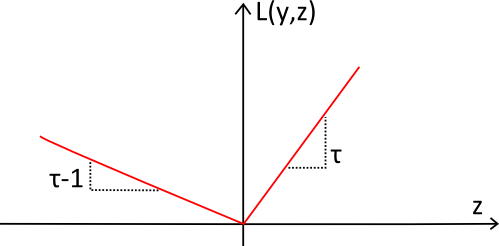

In [ ]:
# Evaluate the model and it's predictions
def evaluation(y_true, predictions):

  print("0.05 percentile:\t{}\n" .format(mean_pinball_loss(y_true, predictions, alpha = 0.05)))
  print("0.5 percentile:\t\t{}\n" .format(mean_pinball_loss(y_true, predictions, alpha = 0.5)))
  print("0.95 percentile:\t{}\n\n" . format(mean_pinball_loss(y_true, predictions, alpha = 0.95)))
  
  # Measuring the algorithm's performance
  print("Mean Squared Error:\t{}\n" . format(mean_squared_error(y_true, predictions)))

In order to make more accurate predictions we will scale the data. Different columns have different value ranges and that could cause problems. Data scaling allows all of the features to be in the same range and improve models' predictions.

We will use **Standardization** to scale down the data, meaning that the dataset will have a zero mean and a variance of 1.

In [ ]:
# Scale the data (with the provided scaler) and return x and y variables
def scale(data, columns, scaler):
  temp = data.copy()
  # We will not scale Weight because it is already scaled
  weight = temp['Weight']
  temp = temp.drop(labels = ['Weight'], axis = 1)
  # Scale data
  temp = scaler.fit_transform(temp)
  
  # Convert to DataFrame so the data is split properly
  temp = pd.DataFrame(temp, columns = columns.drop(labels=['Weight']))
  # Add weight back to dataset
  temp['Weight'] = weight
  # X data
  x_data = temp.drop(labels = ['TargetValue'], axis = 1)
  # Y data - to be predicted
  y_data = temp['TargetValue']

  return x_data, y_data, scaler

In order to get the most accurate model, we will have to find the best hyperparameters from a given set. `GridSearchCV` goes through all of the possible parameter combinations and chooses the best performing one as best parameters. However the **Confirmed Cases** and **Fatalities** datasets are quite big and can take a lot of computation. 

To speed up the computation, we will use `HalvingGridSearchCV`. Similar to `GridSearchCV`, the halving method trains the models on smaller portions of the training data. On the next iteration, only candidates who performed best will be used etc. The training portions only increase for the best performing algorithms.

### Base comparison

In order for us to proceed with the best algorithms, we will compare them how they perform on both datasets with their default settings and we will select the ones with the lowest **MSE** scores. We will test the algorithms on both datasets. We will scale down the data for all of the algorithms so they can be equally measured.

In order to save time, the **Base comparison** algorithms have been commented out and the results have been pre-saved in csv files - `algorithms_confirmed_cases.csv` and `algorithms_fatalities.csv`.

In [ ]:
# Trains models (dictionary) and returns the trained models and their predictions (VALIDATION SET)
def fit_models(regs, x_train, y_train, x_test, y_test):
    fitted_model={}
    model_result = pd.DataFrame()
    for model_name, model in regs.items():
        # Train model
        model.fit(x_train,y_train)
        # Update the model dictionary with trained model
        fitted_model.update({model_name:model})
        # Create a dictionary that is appended to the pandas DataFrame
        model_dict = {}
        model_dict['Algorithm'] = model_name
        model_dict['MSE'] = mean_squared_error(y_test, model.predict(x_test))
        model_result = model_result.append(model_dict,ignore_index=True)
    return fitted_model, model_result

#### Base Algorithm choices

The following algorithms are used to make predictions:

- **Linear Regression** - Regression is one of the main types of supervised learning. It is a technique which investigates the relationship between a dependent variable (target) and independet variables (predictor).
- **XGBoost** - XGBoost is an ensemble algorithm that combines weak learners to form a strong learner and increase the accuracy of the model. Rules help identify a specific class. If a class is identified on an individual learner then the prediction is flawed. Multiple rules are used before determining the class of the final output. In **Gradient Boosting**, the base learners are generated sequentially that the current base learner is more effective from its predecessor. The loss function is optimized of the previous learner. **Extreme Gradient Boosting** has high speed and performance. It is used for regression and classification problems. **XGBoost** is used as a starting point to make accurate predictions for other models.
- **Random Forest** - Random Forests is a supervised machine learning algorithm that is based on ensemble learning. This algorithm combines multiple decision trees, which forms a forest. Initially every tree has the same weight towards the end result. The final result is processed by checking which answer has highest votes. Random Forests can be used for both regression and classification tasks.
- **Multi-layer Perceptron** - Multi-layer Perceptrons are inspired by biological neurons, which have dentrites and axons. An artificial neuron is called a **Perceptron** and it has inputs, a weight for every input, bias and an output. The output is calculated from the summation of the input and weight products, including the bias pass through an activation function.
- **K-Nearest Neighbours** - K-Nearest Neighbours is a simple supervised machine learning algorithm that is used to solve classification and regression problems. This algorithm identifies the k nearest neighbours of new unlabelled data. **K** is the number of nearest neighbours that will be considered when deciding the data's class. A good practice is to choose an **odd K** number so the when deciding the class of the unlabelled data, one class has more votes than the other by one. This algorithm is very easy to use and does not require a lot of maths. However, the cons are that it is memory intensive, new predictions take longer time and there is no real pre-processing. The bigger the **K** parameter is, the more time it will take to compute the label. 
- **Support Vector Machine** - SVM is one of the most popular algorithms for numerical predictions and classification. This algorithm generates the best decision boundary in an iterative way. It aims to maximize the distance between the different classes and minimuse the prediction error.

**NOTE**: Out of all of the algoriths **Support Vector Machine** algorithm took 3 hours to compute the **Confirmed Cases** dataset.

In [ ]:
base_algorithms = {
    "Linear Regression": LinearRegression(),
    "XGB": xgb.XGBRegressor(),
    "Random Forest": RandomForestRegressor(),
    "MLP": MLPRegressor(),
    "KNN": KNeighborsRegressor()
}

# Set up training and validation CASES
scaler_train_cases = StandardScaler()
x_train_cases, y_train_cases, scaler_train_cases = scale(data_cases_train, data_cases_train.columns, scaler_train_cases)

scaler_validate_cases = StandardScaler()
x_validate_cases, y_validate_cases, scaler_validate_cases = scale(data_cases_validate, data_cases_validate.columns, scaler_validate_cases)

# Set up training and validation FATALITIES
scaler_train_fatalities = StandardScaler()
x_train_fatalities, y_train_fatalities, scaler_train_fatalities = scale(data_fatalities_train, data_fatalities_train.columns, scaler_train_fatalities)

scaler_validate_fatalities = StandardScaler()
x_validate_fatalities, y_validate_fatalities, scaler_validate_fatalities = scale(data_fatalities_validate, data_fatalities_validate.columns, scaler_validate_fatalities)

In [ ]:
# Preload the model results
model_result_cases = pd.read_csv(path + "Base comparison/algorithms_confirmed_cases.csv")
model_result_fatalities = pd.read_csv(path + "Base comparison/algorithms_fatalities.csv")

#### Confirmed Cases

In [ ]:
# fitted_model_cases, model_result_cases = fit_models(base_algorithms, x_train_cases, y_train_cases, x_validate_cases, y_validate_cases)
# Save MSE results
# model_result_cases.to_csv(path + "Base comparison/algorithms_confirmed_cases.csv", index=False)

#### Fatalities

In [ ]:
# fitted_model_fatalities, model_result_fatalities = fit_models(base_algorithms, x_train_fatalities, y_train_fatalities, x_validate_fatalities, y_validate_fatalities)
# Save MSE results
# model_result_fatalities.to_csv(path + "Base comparison/algorithms_fatalities.csv", index=False)

#### Results

After running all of the algorithms and getting the Mean Squared Error, we can compare them against each other and decide which ones will be further used for **Confirmed Cases** and **Fatalities**.

In [ ]:
# The smaller MSE is, the better performance the algorithm has
model_result_cases = model_result_cases.sort_values("MSE", ascending = True)
model_result_fatalities = model_result_fatalities.sort_values("MSE", ascending = True)

In [ ]:
# Confirmed Cases
model_result_cases

,Name,MSE
1,XGBoost,0.714866
5,Support Vector Machine,0.730214
3,Multi-layer Perceptron,0.766189
4,K-Nearest Neighbours,0.821554
2,Random Forest,0.876757
0,Linear Regression,0.900404


In [ ]:
# Fatalities
model_result_fatalities

,Name,MSE
1,XGBoost,0.682350
3,Multi-layer Perceptron,0.776725
4,K-Nearest Neighbours,0.778408
5,Support Vector Machine,0.791251
2,Random Forest,0.933637
0,Linear Regression,0.936031


##### Chosen Algorithms

Overall **XGBoost** has best performance for both datasets and will be considered for hyperparameter tuning. It looks like **Random Forest** and **Linear Regression** have the poorest performance for both datasets and will not be taken into further consideration. We will also take into consideration **XGBoost**, **K-Nearest Neighbour**, 
<br><br>
##### Ridge Regression
Although **Linear Regression** has the poorest performance, we will further investigate if Ridge Regression is any better. This is an extension of Linear regression where a regularization term is added to the cost function to reduce overfitting.


###### Confirmed Cases

In [ ]:
ridge = Ridge()

ridge.fit(x_train_cases, y_train_cases)

predictions = ridge.predict(x_validate_cases)

print("MSE Confirmed Cases Ridge Regression:\t{}" .format(mean_squared_error(y_validate_cases, predictions)))

MSE Confirmed Cases Ridge Regression:	0.9004308351652484


###### Fatalities

In [ ]:
ridge = Ridge()

ridge.fit(x_train_fatalities, y_train_fatalities)

predictions = ridge.predict(x_validate_fatalities)

print("MSE Fatalities Ridge Regression:\t{}" .format(mean_squared_error(y_validate_fatalities, predictions)))

MSE Fatalities Ridge Regression:	0.936030397282306


Overall Regression is a poor choice as well and none of the other types of Regression will be further taken into consideration. 

### Hyperparameter Optimization
We will tune the hyperparameters for some of the latter algorithms to see if the performance will improve.

As mentioned above we will use `HalvingGridSearchCV` to search for the best hyperparameters. However we will not be using it on the whole training dataset. We will use it on a smaller part of the training data to speed up the searching process.

Halving Grid Search tries all possibilities with less data and eliminates the poor performing hyperparameters. The better hyperparameters move on to the next round and are given more data. This process is repeated for a given number of time or until there is only 1 combination of hyperparameters which is the most optimal one.

We will use `mean_squared_error` for `scoring` in order to get the best hyperparameters that evaluate the predictions on the data.

In [ ]:
# Trains the models and return a trained model dictionary
def train_models(models, x_train, y_train):
    fitted_models={}
    # Train every model
    for model_name, model in models.items():
        print("{}\tStarting {}" .format(datetime.now().strftime("%H:%M:%S"), model_name))
        model.fit(x_train,y_train)
        fitted_models.update({model_name:model})
        print("{}\tFinished {}\n\n" .format(datetime.now().strftime("%H:%M:%S"), model_name))
    return fitted_models

In [ ]:
# Model prediction for both validate and test datasets
def predict_models(models, x_validate, y_validate, x_test, y_test):
    results = pd.DataFrame()
    for name, model in models.items():

      print("Predictions for {}:\n" .format(name))

      model_dict = {}
      model_dict['Algorithm'] = name

      # VALIDATE predictions
      predictions = model.predict(x_validate)     
      model_dict['MSE Validate'] = mean_squared_error(y_validate, predictions)
      # Print out the algorithm's evaluation - VALIDATE
      evaluation(y_validate, predictions)

      # TEST predictions
      predictions = model.predict(x_test)     
      model_dict['MSE Test'] = mean_squared_error(y_test, predictions)
      # Print out the algorithm's evaluation - TEST
      evaluation(y_test, predictions)

      results = results.append(model_dict,ignore_index=True)

      print("_"*50)
      print("\n")

    return results

In [ ]:
"""
Set the resources - tweaking this parameter 
will decrease the training resources but
could also decrease the chance of finding
the best performing hyperparameters

We will use the entire dataset
"""
resources = int(data_cases_train.shape[0])
print("Maximum resources used in Halving Grid Search: {}" .format(resources))

Maximum resources used in Halving Grid Search: 412097


In [ ]:
# Set up training and validation CONFIRMED CASES
scaler_test_cases = StandardScaler()

x_test_cases, y_test_cases, scaler_test_cases = scale(data_cases_test, data_cases_test.columns, scaler_test_cases)

# Set up training and validation FATALITIES
scaler_test_fatalities = StandardScaler()

x_test_fatalities, y_test_fatalities, scaler_test_fatalities = scale(data_fatalities_test, data_fatalities_test.columns, scaler_test_fatalities)

# Dataframe to store models VALIDATE and TEST MSE scores
model_prediction_results = pd.DataFrame()

In the next sections (**Confirmed Cases** and **Fatalities**) we will choose the best hyperparameters by using `HalvingGridSearchCV` and get the **MSE** for the validation and test sets. The algorithms that we will hypertune are:
- **XGBoost**
- **Multi-layer Perceptron**
- **K-Nearest Neighbours**
- **Random Forest**

Although **Support Vector Machine** has a slightly better performance than **Random Forest**, we will not use **SVM** because of the time it will take to find the best hyperparameters.

#### Confirmed Cases



##### XGBoost

In [ ]:
parameters = {
  'max_depth': range(1, 15, 2),
  'colsample_bytree': [0.8, 1.0, 1.2],     
  'gamma': [0, 0.5, 1, 1.5],   
  'n_estimators': range(50, 250, 50),
  'learning_rate': [0.1, 0.2, 0.3],
  'n_jobs': [-1]
}

xgbr = xgb.XGBRegressor()
halving_grid = HalvingGridSearchCV(estimator=xgbr, param_grid=parameters, cv=3, verbose=10, max_resources=resources, n_jobs=-1, scoring=mean_squared_error)

In [ ]:
# This section is commented because it takes a lot of time to compute
# halving_grid.fit(x_train_cases, y_train_cases)
# print("\nBest parameters\n\n{}" .format(halving_grid.best_params_))

The best set of hyperparameters for XGBoost from all the given ones is:
```
{
  'colsample_bytree': 0.8, 
  'gamma': 1, 
  'learning_rate': 0.3, 
  'max_depth': 13, 
  'n_estimators': 200,
  'n_jobs': -1
}
```

##### Multi-layer Perceptron

In [ ]:
parameters = {
    'hidden_layer_sizes': [(neurons, layers) for neurons in range(10, 230, 30) for layers in range(10, 130, 30)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['adam', 'lbfgs', 'sgd', 'adam']
}

mlp = MLPRegressor()
halving_grid = HalvingGridSearchCV(estimator=mlp, param_grid=parameters, cv=3, verbose=10, max_resources=resources, n_jobs=-1, scoring=mean_squared_error)

In [ ]:
# This section is commented because it takes a lot of time to compute
# halving_grid.fit(x_train_cases, y_train_cases)
# print("\nBest parameters\n\n{}" .format(halving_grid.best_params_))

The best set of hyperparameters for XGBoost from all the given ones is:
```
{
  'activation': 'identity', 
  'hidden_layer_sizes': (220, 100), 
  'solver': 'sgd'
}
```

##### K-Nearest Neighbours

In [ ]:
parameters = {
    'n_neighbors': [n for n in range(3, 40, 2)],
    'weights': ['uniform', 'distance']
}

knn = KNeighborsRegressor()
halving_grid = HalvingGridSearchCV(estimator=knn, param_grid=parameters, cv=3, verbose=10, max_resources=resources, n_jobs=-1, scoring=mean_squared_error)

In [ ]:
# This section is commented because it takes a lot of time to compute
# halving_grid.fit(x_train_cases, y_train_cases)
# print("\nBest parameters:\n\n{}" .format(halving_grid.best_params_))

The best set of hyperparameters for XGBoost from all the given ones is:
```
{
  'n_neighbors': 11, 
  'weights': 'weights'
}
```

##### Random Forest

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 3)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
parameters = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

rgf = RandomForestRegressor()
halving_grid = HalvingGridSearchCV(estimator=rgf, param_grid=parameters, cv=3, verbose=10, max_resources=resources, n_jobs=-1, scoring=mean_squared_error)

In [ ]:
# This section is commented because it takes a lot of time to compute
# halving_grid.fit(x_train_cases, y_train_cases)
# print("\nBest parameters\n\n{}" .format(halving_grid.best_params_))

The best set of hyperparameters for Random Forest from all the given ones is:
```
{
  'bootstrap': True, 
  'max_depth': 60,
  'min_samples_leaf': 2,
  'min_samples_split': 5,
  'n_estimators': 100
}
```

##### Tuned algorithms

In [ ]:
# Tuned algoirthm from latter Grid Search
cases_algorithms = {
    "XGBoost Confirmed Cases": xgb.XGBRegressor(colsample_bytree=0.8, gamma=1, learning_rate=0.3, max_depth=13, n_estimators=200, n_jobs=-1),
    "MLP Confirmed Cases": MLPRegressor(hidden_layer_sizes=(220, 100), solver='sgd', activation='identity'),
    "KNN Confirmed Cases": KNeighborsRegressor(n_neighbors=11, weights='distance'),
    "Random Forest Confirmed Cases": RandomForestRegressor(bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=5, n_estimators=100)
}

# Train the algorithms
cases_algorithms = train_models(cases_algorithms, x_train_cases, y_train_cases)

# Get model predictions
final_results = predict_models(cases_algorithms, x_validate_cases, y_validate_cases, x_test_cases, y_test_cases)
model_prediction_results = model_prediction_results.append(final_results, ignore_index=True)

model_prediction_results

22:22:57	Starting XGBoost Confirmed Cases
[22:22:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
22:24:03	Finished XGBoost Confirmed Cases


22:24:03	Starting MLP Confirmed Cases
22:26:01	Finished MLP Confirmed Cases


22:26:01	Starting KNN Confirmed Cases
22:26:02	Finished KNN Confirmed Cases


22:26:02	Starting Random Forest Confirmed Cases
22:28:15	Finished Random Forest Confirmed Cases


Predictions for XGBoost Confirmed Cases:

0.05 percentile:	0.045691334578452064

0.5 percentile:		0.045569328226357286

0.95 percentile:	0.04544732187426251


Mean Squared Error:	0.8663311274691801

0.05 percentile:	0.049394741666614006

0.5 percentile:		0.048323061800265334

0.95 percentile:	0.04725138193391666


Mean Squared Error:	1.063990070871154

__________________________________________________


Predictions for MLP Confirmed Cases:

0.05 percentile:	0.05717945176036052

0.5 percentile:		0.059999236637142045

0.95 perce

,Algorithm,MSE Test,MSE Validate
0,XGBoost Confirmed Cases,1.063990,0.866331
1,MLP Confirmed Cases,0.914250,0.918171
2,KNN Confirmed Cases,0.953688,0.835017
3,Random Forest Confirmed Cases,1.037323,0.878074


#### Fatalities

##### XGBoost

In [ ]:
parameters = {
  'max_depth': range(1, 15, 2),
  'colsample_bytree': [0.8, 1.0, 1.2],     
  'gamma': [0, 0.5, 1, 1.5],   
  'n_estimators': range(50, 250, 50),
  'learning_rate': [0.1, 0.2, 0.3],
  'n_jobs': [-1]
}

xgbr = xgb.XGBRegressor()
halving_grid = HalvingGridSearchCV(estimator=xgbr, param_grid=parameters, cv=3, verbose=10, max_resources=resources, n_jobs=-1, scoring=mean_squared_error)

In [ ]:
# This section is commented because it takes a lot of time to compute
# halving_grid.fit(x_train_fatalities, y_train_fatalities)
# print("\nBest parameters\n\n{}" .format(halving_grid.best_params_))

The best set of hyperparameters for XGBoost from all the given ones is:
```
{
  'colsample_bytree': 0.8, 
  'gamma': 1, 
  'learning_rate': 0.3, 
  'max_depth': 13, 
  'n_estimators': 200,
  'n_jobs': -1
}
```

##### Multi-layer Perceptron

In [ ]:
parameters = {
    'hidden_layer_sizes': [(neurons, layers) for neurons in range(10, 230, 30) for layers in range(10, 130, 30)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['adam', 'lbfgs', 'sgd', 'adam']
}

mlp = MLPRegressor()
halving_grid = HalvingGridSearchCV(estimator=mlp, param_grid=parameters, cv=3, verbose=10, max_resources=resources, n_jobs=-1, scoring=mean_squared_error)

In [ ]:
# This section is commented because it takes a lot of time to compute
# halving_grid.fit(x_train_fatalities, y_train_fatalities)
# print("\nBest parameters\n\n{}" .format(halving_grid.best_params_))

The best set of hyperparameters for Multi-layer Perceptron from all the given ones is:
```
{
  'activation': 'identity', 
  'hidden_layer_sizes': (220, 100), 
  'solver': 'sgd'
}
```

##### K-Nearest Neighbours

In [ ]:
parameters = {
    'n_neighbors': [n for n in range(3, 40, 2)],
    'weights': ['uniform', 'distance']
}

knn = KNeighborsRegressor()
halving_grid = HalvingGridSearchCV(estimator=knn, param_grid=parameters, cv=3, verbose=10, max_resources=resources, n_jobs=-1, scoring=mean_squared_error)

In [ ]:
# This section is commented because it takes a lot of time to compute
# halving_grid.fit(x_train_fatalities, y_train_fatalities)
# print("\nBest parameters:\n\n{}" .format(halving_grid.best_params_))

The best set of hyperparameters for K-Nearest Neighbours from all the given ones is:
```
{
  'n_neighbors': 11, 
  'weights': 'distance'
}
```

##### Random Forest

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 3)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
parameters = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

rgf = RandomForestRegressor()
halving_grid = HalvingGridSearchCV(estimator=rgf, param_grid=parameters, cv=3, verbose=10, max_resources=resources, n_jobs=-1, scoring=mean_squared_error)

In [ ]:
# This section is commented because it takes a lot of time to compute
# halving_grid.fit(x_train_fatalities, y_train_fatalities)
# print("\nBest parameters\n\n{}" .format(halving_grid.best_params_))

The best set of hyperparameters for Random Forest from all the given ones is:
```
{
  'bootstrap': True, 
  'max_depth': 60,
  'min_samples_leaf': 2,
  'min_samples_split': 5,
  'n_estimators': 100
}
```

##### Tuned algorithms

In [ ]:
# Tuned algoirthm from latter Grid Search
fatalities_algorithms = {
    "XGBoost Fatalities": xgb.XGBRegressor(colsample_bytree=0.8, gamma=1, learning_rate=0.3, max_depth=13, n_estimators=200, n_jobs=-1),
    "MLP Fatalities": MLPRegressor(hidden_layer_sizes=(220, 100), solver='sgd', activation='identity'),
    "KNN Fatalities": KNeighborsRegressor(n_neighbors=11, weights='distance'),
    "Random Forest Fatalities": RandomForestRegressor(bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=5, n_estimators=100)
}

# Train the algorithms
fatalities_algorithms = train_models(fatalities_algorithms, x_train_cases, y_train_cases)

# Get model predictions
final_results = predict_models(fatalities_algorithms, x_validate_fatalities, y_validate_fatalities, x_test_fatalities, y_test_fatalities)
model_prediction_results = model_prediction_results.append(final_results, ignore_index=True)

22:28:18	Starting XGBoost Fatalities
[22:28:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
22:29:27	Finished XGBoost Fatalities


22:29:27	Starting MLP Fatalities
22:33:50	Finished MLP Fatalities


22:33:50	Starting KNN Fatalities
22:33:50	Finished KNN Fatalities


22:33:50	Starting Random Forest Fatalities
22:36:02	Finished Random Forest Fatalities


Predictions for XGBoost Fatalities:

0.05 percentile:	0.0332797483690932

0.5 percentile:		0.03747278929228525

0.95 percentile:	0.0416658302154773


Mean Squared Error:	0.6533224851466904

0.05 percentile:	0.03435004340672436

0.5 percentile:		0.03946318167288776

0.95 percentile:	0.04457631993905115


Mean Squared Error:	0.8838359425532502

__________________________________________________


Predictions for MLP Fatalities:

0.05 percentile:	0.04922814766424274

0.5 percentile:		0.4682944304311626

0.95 percentile:	0.8873607131980823


Mean Squared Error:	1.7951562

#### Results

In [ ]:
model_prediction_results

,Algorithm,MSE Test,MSE Validate
0,XGBoost Confirmed Cases,1.063990,0.866331
1,MLP Confirmed Cases,0.914250,0.918171
2,KNN Confirmed Cases,0.953688,0.835017
3,Random Forest Confirmed Cases,1.037323,0.878074
4,XGBoost Fatalities,0.883836,0.653322
5,MLP Fatalities,1.789655,1.795156
6,KNN Fatalities,1.052317,0.774277
7,Random Forest Fatalities,2.387634,1.692829


Overall both datasets (**Fatalities** and **Confirmed Cases**) are very similar to each other. However the same algorithms (basic forms) give different results for the datasets. For example **XGBoost** does slightly better on the **Fatalities** data rather than on **Confirmed Cases**. The biggest **MSE** difference is in **Random Forest** for both datasets.

In addition `HalvingGridSearchCV` chose the exact same hyperparameters for both datasets, however the performance on the **Fatalities** dataset is slightly better than **Confirmed Cases**. Overall all of the models are underfitting the data - this could be due to how missing data is handled and how the data is prepared to be given to the models.

## Conclusion

This notebook goes over the [COVID19 Global Forecasting (Week 5)](https://www.kaggle.com/c/covid19-global-forecasting-week-5/data?select=test.csv) dataset. 
Firstly we deal with the missing data by using `KNNImputer` and then we explore the dataset and its features. 

When the data was prepared - we check if there are any inconsistencies within it and convert the non numeric features to numeric. **Random Forest** is used to find the dataset features which contribute the most towards the final prediction. Finally the data was split it into two sub datasets based on the **TargetValue** column  **Fatalities** and **Confirmed Cases**. Then we split the data into 3 parts - train, validate and test.

Afterwards we do a base comparison of the following algorithms:
- Linear Regression and Ridge Regression
- XGBoost
- Random Forest
- K-Nearest Neighbours
- Support Vector Machine
- Multi-layer Perceptron

Although SVM has third best performance for both dataset, it is skipped due to taking too computational time. 

Then we tune the hyperparameters of the algorithms (XGBoost, Multi-layer Perceptron, K-nearest Neighbours and Random Forest) with `HalvingGridSearchCV` to speed up the hyperparameter search. 

Unfortunately both base and tuned algorithms underfit the data and further investigation is required why. This could be due to the following reasons:
- The missing data has been imputed using `KNNImputer`. We could try dropping the `NaN` rows instead of imputing them.
- Further investigate if any new features can be developed. In addition the date could also be changed from a single column to 3 columns - day, month and year. The dataset has various different countries and models can be made for a specific country rather than worldwide (as done in this notebook).
- A different method of scaling could be tried as well to see if there is a performance increase.

**NOTE**: We do not use the `test.csv` file to further test the algorithms' performances because they do not perform well enough to be considered for additional testing.

## Thank you for your time ㋡